# Analysis of the autism data

In [36]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [27]:
# Number of experiments when doing the CV
K = 25

In [ ]:
dict_missing_stimulis = {'PopTheBubbles': ['number_of_touches'],
                         'FloatingBubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                            'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                            'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                            'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                            'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative',
                                                'FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'],
                             'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
                             'BlowingBubbles': ['BB_postural_sway', 'BB_postural_sway_derivative',
                                                   'BB_gaze_percent_right', 'BB_gaze_percent_right'],
                            'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                             'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                             'RTNDelay': ['average_response_to_name_delay']}

In [6]:
df =  pd.read_csv(AUTISM_DATA_PATH)

for feature_name_grouped, feats in dict_missing_stimulis.items():
    df['Z_{}'.format(feature_name_grouped)] = 0
    df.loc[df.drop(index=df.dropna(subset=feats, how='any').index).index, 'Z_{}'.format(feature_name_grouped)] = 1

data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = ['Z_'+ i for i in dict_missing_stimulis.keys()], 
                scale_data=False,
                use_missing_indicator_variables=False, 
               verbosity=1,
               scenario='multimodal_2023_regular',#'papers',
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_name = 'Z_stimulis',
                   model_hyperparameters=xgboost_hyperparameters,
                  verbosity=3, 
                  experiment_folder_name='7_December', 
                  save_experiment=False)
exp.fit_predict(num_cv=10, random_state=100)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Predicting diagnosis based on 12 features using xgboost approach.
Performing 10 fold cross-validation.
10-fold Cross-Validation.
Size Train: 339 (295 NT 44 ASD) Test: 38 (33 NT 5 ASD)


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Z_stimulis,0.427,0.147,-0.007,0.03,0.589,0.428,0.044,0.428,0.104,0.135,-0.037,0.98,0.009,0.129,0.022,0.75,0.02,0.871,0.25,48,3,325,1


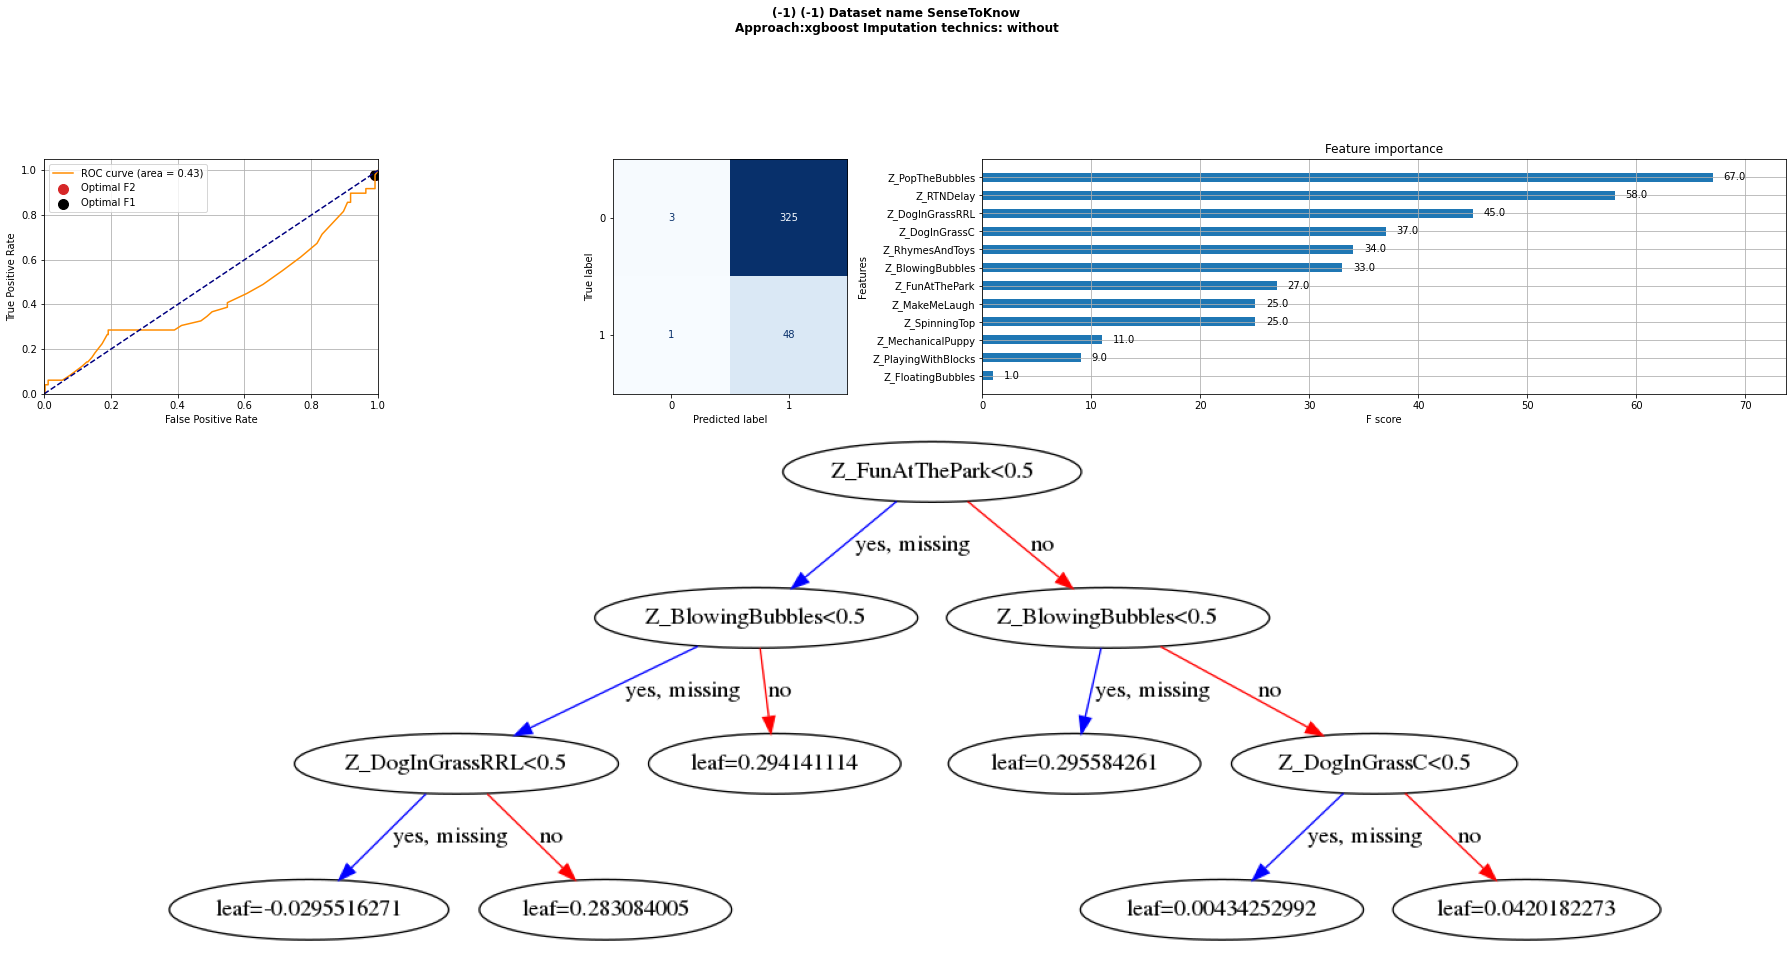

In [7]:
exp.plot()

In [ ]:
for random_state in random_states:

    df =  pd.read_csv(AUTISM_DATA_PATH)

    for feature_name_grouped, feats in dict_missing_stimulis.items():
        df['Z_{}'.format(feature_name_grouped)] = 0
        df.loc[df.drop(index=df.dropna(subset=feats, how='any').index).index, 'Z_{}'.format(feature_name_grouped)] = 1

    data = Dataset(df=df, 
                   missing_data_handling='without', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                    features_name = ['Z_'+ i for i in dict_missing_stimulis.keys()], 
                    scale_data=False,
                    use_missing_indicator_variables=False, 
                   verbosity=1,
                   scenario='multimodal_2023_regular',#'papers',
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach=approach, 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_name = 'Z_stimulis',
                       model_hyperparameters=xgboost_hyperparameters,
                      verbosity=3, 
                      experiment_folder_name='7_December', 
                      save_experiment=False)
    exp.fit_predict(num_cv=10, random_state=random_state)

    display(exp.performances_df)
    exp.plot()
    
    exp._compute_features_importance()



* This section aims at answering a few questions related to the different algorithms used, with the aim of optimizing our classification framework.

**Parameters or potential settings**

* The approach used, which could be Logistic Regression, Decision Tree, Explainable Boosting Machine, Neural Additive models, or XGBoost.
* The use or not of indicator variables as inputs. 
* The scaling of the data. 
* The imputation approach when the learning algorithms does not handle them by design. It could be constant imputation (called encoding here), or conditional imputation (mean, knn, or mice).
* The sampling method in the case of imbalance learning (either no down-sampling, vanilla (random sampling of the minority class until classes are balanced), or SMOTE (a more elaborated sampling).
* The number of features, between 2 and 6. 
* The number of folds when cross-validating the results. 

**Notes on the classification pipeline:**

* Two datasets are age-matched but one (scenario `asd_td_age_matched_n_balanced`) lead to relatively balanced classes, whereas the scenario `asd_td_age_matched_n_unbalanced` has slightly younger kids and so leverage the amount of young neuro-typical kids, and is more unbalanced. 
* No searches on hyper-parameters are performed on each of the approach. Cross-validation is performed with the stratified inner-fold being left-out, the model is fitted on the training set, and the prediction of the test set is done with predictions stored for later evaluation of performances. 
* since a lot of settings parameters are tested, we test all of the hypothesis with a default setting that is: Encoding of the missing variables, scaling of the data, no use of indicator variables, no down-sampling (???), and a 16-fold cross-validation.
* Features selection were made for the two scenario suing the features with the higher importance based on xgboost importance map.
* Classification here is between autistic and neurotypical participants.



**Among the questions at stakes:**

* Experiment 1: Shall we use indicator variables? For each scenario (columns of axes), ad each dimension of the problem (rows of axes) , x is the `use_of_indicator_variables`, y is an indicator of performances (typically the F1 score), and the hue variable are the approaches. The plots are performed for no imputations, 
* Experiement 2: Shall we scale data or not ? 
* Experiment X: for the algorithms handling missing variables (xgboost, nam with encoding) , shall we let them be missing, or imputed ? 

In [22]:
xgboost_hyperparameters = {'scale_pos_weight':None,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

## Experiment 1.  `use_missing_indicator_variables`

In [23]:
approach = 'xgboost'

random_states = np.random.randint(0, 1000, K)
for random_state in random_states:
    for use_missing_indicator_variables in [False, USE_MISSING_INDICATOR_PREDICTORS]:

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = deepcopy(DEFAULT_PREDICTORS), 
                        scale_data=False,
                        use_missing_indicator_variables=use_missing_indicator_variables, 
                       verbosity=1,
                       scenario='multimodal_2023_regular',#'papers',
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          experiment_name = 'use_Z',
                           model_hyperparameters=xgboost_hyperparameters,
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)

        display(exp.performances_df)


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 101!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.891,0.659,0.95,0.356,0.992,0.714,0.186,0.714,0.351,0.83,0.512,0.837,0.829,0.423,0.102,0.971,0.163,0.577,0.029,41,272,56,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 102!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.889,0.653,0.942,0.332,0.991,0.732,0.224,0.732,0.399,0.862,0.556,0.816,0.869,0.482,0.126,0.969,0.184,0.518,0.031,40,285,43,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 103!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.863,0.615,0.945,0.362,0.991,0.644,0.128,0.644,0.261,0.745,0.403,0.837,0.732,0.318,0.068,0.968,0.163,0.682,0.032,41,240,88,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 104!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.859,0.602,0.935,0.318,0.99,0.637,0.24,0.637,0.391,0.875,0.509,0.653,0.909,0.516,0.142,0.946,0.347,0.484,0.054,32,298,30,17


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 105!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 106!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.63,0.943,0.323,0.99,0.694,0.144,0.694,0.291,0.767,0.459,0.898,0.747,0.346,0.076,0.98,0.102,0.654,0.02,44,245,83,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 107!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.635,0.945,0.342,0.991,0.673,0.166,0.673,0.319,0.812,0.465,0.796,0.814,0.39,0.091,0.964,0.204,0.61,0.036,39,267,61,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 108!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.658,0.957,0.421,0.993,0.695,0.177,0.695,0.336,0.82,0.476,0.796,0.823,0.402,0.095,0.964,0.204,0.598,0.036,39,270,58,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 109!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.86,0.635,0.948,0.378,0.992,0.638,0.115,0.638,0.241,0.706,0.384,0.878,0.68,0.291,0.06,0.974,0.122,0.709,0.026,43,223,105,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 110!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.872,0.655,0.957,0.427,0.993,0.662,0.156,0.662,0.303,0.798,0.446,0.796,0.799,0.371,0.084,0.963,0.204,0.629,0.037,39,262,66,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 111!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.853,0.596,0.935,0.324,0.99,0.663,0.148,0.663,0.293,0.785,0.439,0.816,0.78,0.357,0.08,0.966,0.184,0.643,0.034,40,256,72,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 112!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.858,0.585,0.928,0.295,0.989,0.657,0.143,0.657,0.285,0.777,0.429,0.816,0.771,0.348,0.077,0.966,0.184,0.652,0.034,40,253,75,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 113!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.876,0.622,0.941,0.342,0.991,0.671,0.134,0.671,0.273,0.751,0.43,0.878,0.732,0.328,0.071,0.976,0.122,0.672,0.024,43,240,88,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 114!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.875,0.623,0.942,0.319,0.99,0.694,0.144,0.694,0.291,0.767,0.459,0.898,0.747,0.346,0.076,0.98,0.102,0.654,0.02,44,245,83,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 115!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.655,0.951,0.38,0.992,0.67,0.154,0.67,0.301,0.793,0.449,0.816,0.79,0.367,0.083,0.966,0.184,0.633,0.034,40,259,69,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 116!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.636,0.947,0.351,0.992,0.669,0.162,0.669,0.312,0.806,0.457,0.796,0.808,0.382,0.088,0.964,0.204,0.618,0.036,39,265,63,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 117!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.855,0.575,0.924,0.293,0.988,0.647,0.12,0.647,0.249,0.719,0.397,0.878,0.695,0.301,0.063,0.974,0.122,0.699,0.026,43,228,100,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 118!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.857,0.577,0.926,0.3,0.989,0.648,0.131,0.648,0.266,0.751,0.409,0.837,0.738,0.323,0.069,0.968,0.163,0.677,0.032,41,242,86,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 119!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.65,0.954,0.403,0.993,0.668,0.138,0.668,0.278,0.756,0.404,0.816,0.747,0.325,0.07,0.965,0.184,0.675,0.035,40,245,83,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 120!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.646,0.955,0.398,0.993,0.66,0.122,0.66,0.255,0.721,0.41,0.898,0.695,0.306,0.064,0.979,0.102,0.694,0.021,44,228,100,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 121!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.607,0.937,0.326,0.99,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 122!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.604,0.93,0.296,0.988,0.677,0.182,0.677,0.339,0.83,0.482,0.776,0.838,0.418,0.1,0.962,0.224,0.582,0.038,38,275,53,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 123!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 124!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.63,0.943,0.323,0.99,0.694,0.144,0.694,0.291,0.767,0.459,0.898,0.747,0.346,0.076,0.98,0.102,0.654,0.02,44,245,83,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 125!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.541,0.898,0.206,0.965,0.679,0.162,0.679,0.313,0.801,0.45,0.796,0.802,0.375,0.085,0.963,0.204,0.625,0.037,39,263,65,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 126!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.863,0.54,0.895,0.2,0.962,0.68,0.147,0.68,0.293,0.775,0.437,0.837,0.765,0.347,0.077,0.969,0.163,0.653,0.031,41,251,77,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 127!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.582,0.915,0.266,0.986,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 128!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.88,0.593,0.915,0.268,0.985,0.664,0.181,0.664,0.334,0.828,0.458,0.735,0.841,0.409,0.097,0.955,0.265,0.591,0.045,36,276,52,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 129!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.621,0.933,0.309,0.989,0.704,0.188,0.704,0.351,0.83,0.492,0.796,0.835,0.419,0.101,0.965,0.204,0.581,0.035,39,274,54,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 130!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.61,0.938,0.307,0.989,0.675,0.179,0.675,0.335,0.825,0.464,0.755,0.835,0.407,0.096,0.958,0.245,0.593,0.042,37,274,54,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 131!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.617,0.938,0.32,0.99,0.695,0.177,0.695,0.336,0.822,0.49,0.816,0.823,0.408,0.097,0.968,0.184,0.592,0.032,40,270,58,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 132!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.639,0.948,0.36,0.992,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 133!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.838,0.567,0.917,0.301,0.987,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 134!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.85,0.578,0.916,0.288,0.987,0.68,0.173,0.68,0.329,0.82,0.476,0.796,0.823,0.402,0.095,0.964,0.204,0.598,0.036,39,270,58,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 135!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.612,0.94,0.329,0.991,0.673,0.148,0.673,0.294,0.782,0.446,0.837,0.774,0.357,0.079,0.969,0.163,0.643,0.031,41,254,74,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 136!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.866,0.593,0.926,0.291,0.988,0.693,0.165,0.693,0.32,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 137!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.623,0.944,0.339,0.991,0.679,0.162,0.679,0.313,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 138!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.643,0.951,0.373,0.992,0.68,0.154,0.68,0.303,0.79,0.456,0.837,0.784,0.366,0.082,0.97,0.163,0.634,0.03,41,257,71,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 139!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.863,0.587,0.922,0.285,0.988,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 140!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.867,0.605,0.932,0.309,0.989,0.655,0.124,0.655,0.257,0.729,0.408,0.878,0.707,0.309,0.065,0.975,0.122,0.691,0.025,43,232,96,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 141!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.858,0.613,0.936,0.324,0.99,0.651,0.139,0.651,0.278,0.769,0.42,0.816,0.762,0.339,0.074,0.965,0.184,0.661,0.035,40,250,78,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 142!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.866,0.619,0.941,0.338,0.991,0.647,0.12,0.647,0.249,0.719,0.397,0.878,0.695,0.301,0.063,0.974,0.122,0.699,0.026,43,228,100,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 143!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.665,0.955,0.387,0.993,0.675,0.212,0.675,0.373,0.854,0.494,0.714,0.875,0.461,0.117,0.953,0.286,0.539,0.047,35,287,41,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 144!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.859,0.62,0.937,0.329,0.99,0.688,0.17,0.688,0.326,0.812,0.465,0.796,0.814,0.39,0.091,0.964,0.204,0.61,0.036,39,267,61,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 145!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.864,0.618,0.945,0.365,0.992,0.669,0.132,0.669,0.271,0.748,0.427,0.878,0.729,0.326,0.07,0.976,0.122,0.674,0.024,43,239,89,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 146!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.869,0.647,0.953,0.397,0.993,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 147!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.88,0.628,0.946,0.329,0.988,0.684,0.157,0.684,0.308,0.788,0.422,0.776,0.79,0.355,0.079,0.959,0.224,0.645,0.041,38,259,69,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 148!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.878,0.639,0.951,0.371,0.992,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 149!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.884,0.642,0.939,0.33,0.99,0.712,0.173,0.712,0.334,0.814,0.499,0.857,0.808,0.4,0.094,0.974,0.143,0.6,0.026,42,265,63,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 150!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.879,0.681,0.963,0.458,0.994,0.677,0.182,0.677,0.339,0.83,0.482,0.776,0.838,0.418,0.1,0.962,0.224,0.582,0.038,38,275,53,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 151!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 152!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.862,0.561,0.903,0.236,0.977,0.669,0.145,0.669,0.289,0.777,0.44,0.837,0.768,0.35,0.077,0.969,0.163,0.65,0.031,41,252,76,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 153!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.876,0.625,0.938,0.316,0.99,0.674,0.142,0.674,0.286,0.769,0.441,0.857,0.756,0.344,0.076,0.973,0.143,0.656,0.027,42,248,80,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 154!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.624,0.938,0.298,0.987,0.699,0.195,0.699,0.359,0.841,0.51,0.796,0.848,0.438,0.108,0.965,0.204,0.562,0.035,39,278,50,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 155!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.867,0.604,0.929,0.317,0.989,0.664,0.124,0.664,0.258,0.727,0.416,0.898,0.701,0.31,0.065,0.979,0.102,0.69,0.021,44,230,98,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 156!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.633,0.945,0.349,0.991,0.672,0.156,0.672,0.304,0.793,0.439,0.796,0.793,0.364,0.082,0.963,0.204,0.636,0.037,39,260,68,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 157!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.887,0.656,0.951,0.355,0.991,0.704,0.188,0.704,0.351,0.833,0.507,0.816,0.835,0.426,0.103,0.968,0.184,0.574,0.032,40,274,54,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 158!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.637,0.945,0.331,0.99,0.682,0.155,0.682,0.305,0.79,0.446,0.816,0.787,0.364,0.082,0.966,0.184,0.636,0.034,40,258,70,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 159!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.873,0.586,0.918,0.277,0.987,0.705,0.167,0.705,0.324,0.806,0.488,0.857,0.799,0.389,0.09,0.974,0.143,0.611,0.026,42,262,66,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 160!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.596,0.926,0.271,0.985,0.68,0.154,0.68,0.303,0.79,0.456,0.837,0.784,0.366,0.082,0.97,0.163,0.634,0.03,41,257,71,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 161!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.859,0.569,0.919,0.239,0.973,0.656,0.136,0.656,0.275,0.756,0.393,0.796,0.75,0.322,0.069,0.961,0.204,0.678,0.039,39,246,82,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 162!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.577,0.921,0.247,0.98,0.679,0.185,0.679,0.343,0.833,0.487,0.776,0.841,0.422,0.102,0.962,0.224,0.578,0.038,38,276,52,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 163!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.876,0.645,0.953,0.384,0.993,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 164!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.88,0.649,0.951,0.379,0.992,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 165!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.866,0.654,0.956,0.408,0.993,0.682,0.155,0.682,0.305,0.793,0.46,0.837,0.787,0.369,0.084,0.97,0.163,0.631,0.03,41,258,70,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 166!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.63,0.947,0.353,0.992,0.674,0.142,0.674,0.286,0.769,0.441,0.857,0.756,0.344,0.076,0.973,0.143,0.656,0.027,42,248,80,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 167!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.863,0.618,0.946,0.36,0.992,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 168!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.875,0.588,0.917,0.27,0.986,0.683,0.166,0.683,0.319,0.809,0.471,0.816,0.808,0.388,0.09,0.967,0.184,0.612,0.033,40,265,63,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 169!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.626,0.937,0.329,0.99,0.674,0.158,0.674,0.307,0.796,0.443,0.796,0.796,0.368,0.083,0.963,0.204,0.632,0.037,39,261,67,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 170!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.63,0.945,0.322,0.984,0.656,0.15,0.656,0.294,0.79,0.436,0.796,0.79,0.361,0.081,0.963,0.204,0.639,0.037,39,259,69,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 171!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.872,0.661,0.957,0.406,0.993,0.671,0.147,0.671,0.292,0.775,0.415,0.796,0.771,0.342,0.075,0.962,0.204,0.658,0.038,39,253,75,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 172!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.869,0.649,0.952,0.377,0.992,0.675,0.179,0.675,0.335,0.828,0.478,0.776,0.835,0.413,0.099,0.961,0.224,0.587,0.039,38,274,54,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 173!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.863,0.629,0.944,0.355,0.991,0.656,0.136,0.656,0.275,0.761,0.421,0.837,0.75,0.333,0.072,0.969,0.163,0.667,0.031,41,246,82,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 174!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.872,0.645,0.944,0.352,0.991,0.651,0.179,0.651,0.33,0.828,0.448,0.714,0.845,0.407,0.097,0.952,0.286,0.593,0.048,35,277,51,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 175!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.63,0.947,0.356,0.992,0.686,0.159,0.686,0.311,0.798,0.467,0.837,0.793,0.376,0.086,0.97,0.163,0.624,0.03,41,260,68,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 176!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.875,0.638,0.953,0.386,0.993,0.678,0.171,0.678,0.325,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 177!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.631,0.947,0.355,0.992,0.679,0.139,0.679,0.282,0.761,0.442,0.878,0.744,0.339,0.074,0.976,0.122,0.661,0.024,43,244,84,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 178!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.879,0.625,0.932,0.314,0.989,0.695,0.177,0.695,0.336,0.822,0.49,0.816,0.823,0.408,0.097,0.968,0.184,0.592,0.032,40,270,58,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 179!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.869,0.644,0.953,0.393,0.993,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 180!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.639,0.947,0.352,0.991,0.677,0.16,0.677,0.31,0.801,0.46,0.816,0.799,0.377,0.086,0.967,0.184,0.623,0.033,40,262,66,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 181!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.581,0.92,0.247,0.973,0.719,0.17,0.719,0.331,0.809,0.502,0.878,0.799,0.394,0.092,0.978,0.122,0.606,0.022,43,262,66,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 182!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.596,0.931,0.266,0.982,0.681,0.164,0.681,0.316,0.806,0.467,0.816,0.805,0.385,0.089,0.967,0.184,0.615,0.033,40,264,64,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 183!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.59,0.929,0.251,0.967,0.679,0.185,0.679,0.343,0.833,0.487,0.776,0.841,0.422,0.102,0.962,0.224,0.578,0.038,38,276,52,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 184!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.878,0.611,0.942,0.284,0.972,0.675,0.179,0.675,0.335,0.828,0.478,0.776,0.835,0.413,0.099,0.961,0.224,0.587,0.039,38,274,54,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 185!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.634,0.95,0.366,0.992,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 186!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.589,0.928,0.293,0.989,0.685,0.143,0.685,0.289,0.769,0.451,0.878,0.753,0.347,0.076,0.976,0.122,0.653,0.024,43,247,81,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 187!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 188!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.862,0.561,0.903,0.236,0.977,0.669,0.145,0.669,0.289,0.777,0.44,0.837,0.768,0.35,0.077,0.969,0.163,0.65,0.031,41,252,76,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 189!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.868,0.647,0.948,0.365,0.992,0.648,0.131,0.648,0.266,0.751,0.409,0.837,0.738,0.323,0.069,0.968,0.163,0.677,0.032,41,242,86,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 190!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.869,0.663,0.953,0.391,0.993,0.65,0.325,0.65,0.466,0.905,0.578,0.633,0.945,0.633,0.211,0.945,0.367,0.367,0.055,31,310,18,18


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 191!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.64,0.95,0.361,0.992,0.698,0.161,0.698,0.315,0.798,0.477,0.857,0.79,0.378,0.087,0.974,0.143,0.622,0.026,42,259,69,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 192!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.882,0.632,0.942,0.326,0.991,0.684,0.191,0.684,0.351,0.838,0.495,0.776,0.848,0.432,0.106,0.962,0.224,0.568,0.038,38,278,50,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 193!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.879,0.639,0.952,0.373,0.992,0.689,0.153,0.689,0.304,0.788,0.463,0.857,0.777,0.365,0.082,0.973,0.143,0.635,0.027,42,255,73,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 194!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.877,0.613,0.938,0.32,0.99,0.684,0.157,0.684,0.308,0.793,0.449,0.816,0.79,0.367,0.083,0.966,0.184,0.633,0.034,40,259,69,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 195!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.878,0.648,0.952,0.377,0.993,0.7,0.163,0.7,0.318,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 196!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.874,0.645,0.95,0.367,0.992,0.677,0.138,0.677,0.28,0.759,0.439,0.878,0.741,0.336,0.073,0.976,0.122,0.664,0.024,43,243,85,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 197!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.87,0.597,0.929,0.303,0.989,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 198!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.622,0.937,0.325,0.99,0.66,0.132,0.66,0.269,0.751,0.42,0.857,0.735,0.326,0.07,0.972,0.143,0.674,0.028,42,241,87,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 199!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.867,0.615,0.943,0.34,0.991,0.692,0.148,0.692,0.297,0.777,0.461,0.878,0.762,0.355,0.079,0.977,0.122,0.645,0.023,43,250,78,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 200!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,use_Z,0.871,0.618,0.943,0.343,0.991,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


## Experiment 2  `scale_data`

In [25]:
random_states = np.random.randint(0, 1000, K)
for random_state in random_states:
    for scale_data in [True, False]:


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = deepcopy(DEFAULT_PREDICTORS), 
                        scale_data=scale_data,
                        use_missing_indicator_variables=False, 
                       verbosity=0,
                       scenario='multimodal_2023_regular',#'papers',
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Scale Data',
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 201!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.891,0.659,0.95,0.356,0.992,0.714,0.186,0.714,0.351,0.83,0.512,0.837,0.829,0.423,0.102,0.971,0.163,0.577,0.029,41,272,56,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 202!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.891,0.659,0.95,0.356,0.992,0.714,0.186,0.714,0.351,0.83,0.512,0.837,0.829,0.423,0.102,0.971,0.163,0.577,0.029,41,272,56,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 203!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.615,0.945,0.362,0.991,0.644,0.128,0.644,0.261,0.745,0.403,0.837,0.732,0.318,0.068,0.968,0.163,0.682,0.032,41,240,88,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 204!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.615,0.945,0.362,0.991,0.644,0.128,0.644,0.261,0.745,0.403,0.837,0.732,0.318,0.068,0.968,0.163,0.682,0.032,41,240,88,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 205!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 206!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 207!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.636,0.945,0.342,0.991,0.673,0.166,0.673,0.319,0.812,0.465,0.796,0.814,0.39,0.091,0.964,0.204,0.61,0.036,39,267,61,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 208!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.635,0.945,0.342,0.991,0.673,0.166,0.673,0.319,0.812,0.465,0.796,0.814,0.39,0.091,0.964,0.204,0.61,0.036,39,267,61,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 209!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.86,0.635,0.948,0.378,0.992,0.638,0.115,0.638,0.241,0.706,0.384,0.878,0.68,0.291,0.06,0.974,0.122,0.709,0.026,43,223,105,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 210!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.86,0.635,0.948,0.378,0.992,0.638,0.115,0.638,0.241,0.706,0.384,0.878,0.68,0.291,0.06,0.974,0.122,0.709,0.026,43,223,105,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 211!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.853,0.597,0.936,0.324,0.99,0.663,0.148,0.663,0.293,0.785,0.439,0.816,0.78,0.357,0.08,0.966,0.184,0.643,0.034,40,256,72,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 212!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.853,0.596,0.935,0.324,0.99,0.663,0.148,0.663,0.293,0.785,0.439,0.816,0.78,0.357,0.08,0.966,0.184,0.643,0.034,40,256,72,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 213!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.622,0.941,0.342,0.991,0.671,0.134,0.671,0.273,0.751,0.43,0.878,0.732,0.328,0.071,0.976,0.122,0.672,0.024,43,240,88,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 214!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.622,0.941,0.342,0.991,0.671,0.134,0.671,0.273,0.751,0.43,0.878,0.732,0.328,0.071,0.976,0.122,0.672,0.024,43,240,88,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 215!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.873,0.655,0.951,0.38,0.992,0.67,0.154,0.67,0.301,0.793,0.449,0.816,0.79,0.367,0.083,0.966,0.184,0.633,0.034,40,259,69,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 216!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.873,0.655,0.951,0.38,0.992,0.67,0.154,0.67,0.301,0.793,0.449,0.816,0.79,0.367,0.083,0.966,0.184,0.633,0.034,40,259,69,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 217!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.855,0.575,0.924,0.293,0.988,0.647,0.12,0.647,0.249,0.719,0.397,0.878,0.695,0.301,0.063,0.974,0.122,0.699,0.026,43,228,100,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 218!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.855,0.575,0.924,0.293,0.988,0.647,0.12,0.647,0.249,0.719,0.397,0.878,0.695,0.301,0.063,0.974,0.122,0.699,0.026,43,228,100,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 219!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.869,0.65,0.954,0.403,0.993,0.668,0.138,0.668,0.278,0.756,0.404,0.816,0.747,0.325,0.07,0.965,0.184,0.675,0.035,40,245,83,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 220!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.65,0.954,0.403,0.993,0.668,0.138,0.668,0.278,0.756,0.404,0.816,0.747,0.325,0.07,0.965,0.184,0.675,0.035,40,245,83,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 221!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.874,0.608,0.938,0.326,0.99,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 222!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.874,0.607,0.937,0.326,0.99,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 223!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 224!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.881,0.596,0.922,0.263,0.983,0.681,0.141,0.681,0.285,0.764,0.445,0.878,0.747,0.341,0.075,0.976,0.122,0.659,0.024,43,245,83,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 225!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.867,0.541,0.898,0.206,0.965,0.679,0.162,0.679,0.313,0.801,0.45,0.796,0.802,0.375,0.085,0.963,0.204,0.625,0.037,39,263,65,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 226!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.541,0.898,0.206,0.965,0.679,0.162,0.679,0.313,0.801,0.45,0.796,0.802,0.375,0.085,0.963,0.204,0.625,0.037,39,263,65,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 227!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.874,0.582,0.915,0.266,0.986,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 228!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.874,0.582,0.915,0.266,0.986,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 229!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.882,0.621,0.933,0.309,0.989,0.704,0.188,0.704,0.351,0.83,0.492,0.796,0.835,0.419,0.101,0.965,0.204,0.581,0.035,39,274,54,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 230!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.882,0.621,0.933,0.309,0.989,0.704,0.188,0.704,0.351,0.83,0.492,0.796,0.835,0.419,0.101,0.965,0.204,0.581,0.035,39,274,54,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 231!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.617,0.938,0.32,0.99,0.695,0.177,0.695,0.336,0.822,0.49,0.816,0.823,0.408,0.097,0.968,0.184,0.592,0.032,40,270,58,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 232!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.617,0.938,0.32,0.99,0.695,0.177,0.695,0.336,0.822,0.49,0.816,0.823,0.408,0.097,0.968,0.184,0.592,0.032,40,270,58,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 233!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.838,0.567,0.917,0.301,0.987,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 234!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.838,0.567,0.917,0.301,0.987,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 235!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.612,0.94,0.33,0.991,0.673,0.148,0.673,0.294,0.782,0.446,0.837,0.774,0.357,0.079,0.969,0.163,0.643,0.031,41,254,74,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 236!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.612,0.94,0.329,0.991,0.673,0.148,0.673,0.294,0.782,0.446,0.837,0.774,0.357,0.079,0.969,0.163,0.643,0.031,41,254,74,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 237!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.623,0.944,0.339,0.991,0.679,0.162,0.679,0.313,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 238!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.623,0.944,0.339,0.991,0.679,0.162,0.679,0.313,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 239!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.587,0.922,0.285,0.988,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 240!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.587,0.922,0.285,0.988,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 241!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.858,0.613,0.936,0.324,0.99,0.651,0.139,0.651,0.278,0.769,0.42,0.816,0.762,0.339,0.074,0.965,0.184,0.661,0.035,40,250,78,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 242!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.858,0.613,0.936,0.324,0.99,0.651,0.139,0.651,0.278,0.769,0.42,0.816,0.762,0.339,0.074,0.965,0.184,0.661,0.035,40,250,78,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 243!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.872,0.665,0.954,0.387,0.993,0.675,0.212,0.675,0.373,0.854,0.494,0.714,0.875,0.461,0.117,0.953,0.286,0.539,0.047,35,287,41,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 244!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.873,0.665,0.955,0.387,0.993,0.675,0.212,0.675,0.373,0.854,0.494,0.714,0.875,0.461,0.117,0.953,0.286,0.539,0.047,35,287,41,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 245!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.864,0.618,0.945,0.365,0.992,0.669,0.132,0.669,0.271,0.748,0.427,0.878,0.729,0.326,0.07,0.976,0.122,0.674,0.024,43,239,89,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 246!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.864,0.618,0.945,0.365,0.992,0.669,0.132,0.669,0.271,0.748,0.427,0.878,0.729,0.326,0.07,0.976,0.122,0.674,0.024,43,239,89,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 247!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.88,0.628,0.946,0.329,0.988,0.684,0.157,0.684,0.308,0.788,0.422,0.776,0.79,0.355,0.079,0.959,0.224,0.645,0.041,38,259,69,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 248!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.88,0.628,0.946,0.329,0.988,0.684,0.157,0.684,0.308,0.788,0.422,0.776,0.79,0.355,0.079,0.959,0.224,0.645,0.041,38,259,69,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 249!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.884,0.642,0.939,0.33,0.99,0.712,0.173,0.712,0.334,0.814,0.499,0.857,0.808,0.4,0.094,0.974,0.143,0.6,0.026,42,265,63,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 250!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.884,0.642,0.939,0.33,0.99,0.712,0.173,0.712,0.334,0.814,0.499,0.857,0.808,0.4,0.094,0.974,0.143,0.6,0.026,42,265,63,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 251!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 252!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 253!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.625,0.938,0.316,0.99,0.674,0.142,0.674,0.286,0.769,0.441,0.857,0.756,0.344,0.076,0.973,0.143,0.656,0.027,42,248,80,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 254!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.625,0.938,0.316,0.99,0.674,0.142,0.674,0.286,0.769,0.441,0.857,0.756,0.344,0.076,0.973,0.143,0.656,0.027,42,248,80,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 255!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.867,0.604,0.929,0.317,0.989,0.664,0.124,0.664,0.258,0.727,0.416,0.898,0.701,0.31,0.065,0.979,0.102,0.69,0.021,44,230,98,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 256!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.867,0.604,0.929,0.317,0.989,0.664,0.124,0.664,0.258,0.727,0.416,0.898,0.701,0.31,0.065,0.979,0.102,0.69,0.021,44,230,98,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 257!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.887,0.656,0.951,0.355,0.991,0.704,0.188,0.704,0.351,0.833,0.507,0.816,0.835,0.426,0.103,0.968,0.184,0.574,0.032,40,274,54,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 258!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.887,0.656,0.951,0.355,0.991,0.704,0.188,0.704,0.351,0.833,0.507,0.816,0.835,0.426,0.103,0.968,0.184,0.574,0.032,40,274,54,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 259!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.873,0.586,0.918,0.277,0.987,0.705,0.167,0.705,0.324,0.806,0.488,0.857,0.799,0.389,0.09,0.974,0.143,0.611,0.026,42,262,66,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 260!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.873,0.586,0.918,0.277,0.987,0.705,0.167,0.705,0.324,0.806,0.488,0.857,0.799,0.389,0.09,0.974,0.143,0.611,0.026,42,262,66,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 261!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.859,0.569,0.919,0.239,0.973,0.656,0.136,0.656,0.275,0.756,0.393,0.796,0.75,0.322,0.069,0.961,0.204,0.678,0.039,39,246,82,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 262!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.859,0.569,0.919,0.239,0.973,0.656,0.136,0.656,0.275,0.756,0.393,0.796,0.75,0.322,0.069,0.961,0.204,0.678,0.039,39,246,82,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 263!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.645,0.953,0.384,0.993,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 264!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.876,0.645,0.953,0.384,0.993,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 265!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.866,0.654,0.956,0.408,0.993,0.682,0.155,0.682,0.305,0.793,0.46,0.837,0.787,0.369,0.084,0.97,0.163,0.631,0.03,41,258,70,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 266!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.866,0.654,0.956,0.408,0.993,0.682,0.155,0.682,0.305,0.793,0.46,0.837,0.787,0.369,0.084,0.97,0.163,0.631,0.03,41,258,70,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 267!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.619,0.946,0.361,0.992,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 268!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.618,0.946,0.36,0.992,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 269!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.626,0.937,0.329,0.99,0.674,0.158,0.674,0.307,0.796,0.443,0.796,0.796,0.368,0.083,0.963,0.204,0.632,0.037,39,261,67,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 270!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.626,0.937,0.329,0.99,0.674,0.158,0.674,0.307,0.796,0.443,0.796,0.796,0.368,0.083,0.963,0.204,0.632,0.037,39,261,67,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 271!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.872,0.661,0.957,0.406,0.993,0.671,0.147,0.671,0.292,0.775,0.415,0.796,0.771,0.342,0.075,0.962,0.204,0.658,0.038,39,253,75,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 272!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.872,0.661,0.957,0.406,0.993,0.671,0.147,0.671,0.292,0.775,0.415,0.796,0.771,0.342,0.075,0.962,0.204,0.658,0.038,39,253,75,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 273!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.629,0.944,0.355,0.991,0.656,0.136,0.656,0.275,0.761,0.421,0.837,0.75,0.333,0.072,0.969,0.163,0.667,0.031,41,246,82,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 274!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.863,0.629,0.944,0.355,0.991,0.656,0.136,0.656,0.275,0.761,0.421,0.837,0.75,0.333,0.072,0.969,0.163,0.667,0.031,41,246,82,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 275!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.631,0.948,0.357,0.992,0.686,0.159,0.686,0.311,0.798,0.467,0.837,0.793,0.376,0.086,0.97,0.163,0.624,0.03,41,260,68,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 276!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.63,0.947,0.356,0.992,0.686,0.159,0.686,0.311,0.798,0.467,0.837,0.793,0.376,0.086,0.97,0.163,0.624,0.03,41,260,68,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 277!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.631,0.947,0.355,0.992,0.679,0.139,0.679,0.282,0.761,0.442,0.878,0.744,0.339,0.074,0.976,0.122,0.661,0.024,43,244,84,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 278!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.631,0.947,0.355,0.992,0.679,0.139,0.679,0.282,0.761,0.442,0.878,0.744,0.339,0.074,0.976,0.122,0.661,0.024,43,244,84,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 279!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.869,0.644,0.953,0.393,0.993,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 280!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.869,0.644,0.953,0.393,0.993,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 281!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.581,0.92,0.247,0.973,0.719,0.17,0.719,0.331,0.809,0.502,0.878,0.799,0.394,0.092,0.978,0.122,0.606,0.022,43,262,66,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 282!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.877,0.581,0.92,0.247,0.973,0.719,0.17,0.719,0.331,0.809,0.502,0.878,0.799,0.394,0.092,0.978,0.122,0.606,0.022,43,262,66,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 283!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.59,0.929,0.251,0.967,0.679,0.185,0.679,0.343,0.833,0.487,0.776,0.841,0.422,0.102,0.962,0.224,0.578,0.038,38,276,52,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 284!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.59,0.929,0.251,0.967,0.679,0.185,0.679,0.343,0.833,0.487,0.776,0.841,0.422,0.102,0.962,0.224,0.578,0.038,38,276,52,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 285!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.634,0.95,0.366,0.992,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 286!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.634,0.95,0.366,0.992,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 287!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 288!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.857,0.557,0.903,0.239,0.982,0.655,0.142,0.655,0.283,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 289!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.648,0.948,0.365,0.992,0.648,0.131,0.648,0.266,0.751,0.409,0.837,0.738,0.323,0.069,0.968,0.163,0.677,0.032,41,242,86,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 290!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.868,0.647,0.948,0.365,0.992,0.648,0.131,0.648,0.266,0.751,0.409,0.837,0.738,0.323,0.069,0.968,0.163,0.677,0.032,41,242,86,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 291!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.882,0.64,0.951,0.361,0.992,0.698,0.161,0.698,0.315,0.798,0.477,0.857,0.79,0.378,0.087,0.974,0.143,0.622,0.026,42,259,69,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 292!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.882,0.64,0.95,0.361,0.992,0.698,0.161,0.698,0.315,0.798,0.477,0.857,0.79,0.378,0.087,0.974,0.143,0.622,0.026,42,259,69,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 293!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.879,0.639,0.952,0.373,0.992,0.689,0.153,0.689,0.304,0.788,0.463,0.857,0.777,0.365,0.082,0.973,0.143,0.635,0.027,42,255,73,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 294!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.879,0.639,0.952,0.373,0.992,0.689,0.153,0.689,0.304,0.788,0.463,0.857,0.777,0.365,0.082,0.973,0.143,0.635,0.027,42,255,73,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 295!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.878,0.648,0.952,0.377,0.993,0.7,0.163,0.7,0.318,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 296!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.878,0.648,0.952,0.377,0.993,0.7,0.163,0.7,0.318,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 297!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.597,0.929,0.303,0.989,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 298!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.87,0.597,0.929,0.303,0.989,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 299!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.867,0.615,0.943,0.34,0.991,0.692,0.148,0.692,0.297,0.777,0.461,0.878,0.762,0.355,0.079,0.977,0.122,0.645,0.023,43,250,78,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 300!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Scale Data,0.867,0.615,0.943,0.34,0.991,0.692,0.148,0.692,0.297,0.777,0.461,0.878,0.762,0.355,0.079,0.977,0.122,0.645,0.023,43,250,78,6


## Experiment 3. `Imputation approach`

In [ ]:
random_states = np.random.randint(0, 1000, K)
for random_state in random_states:

    for imputation_method in ['without','mice', 'knn', 'mean', 'constant']:

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='imputation',
                       imputation_method=imputation_method,
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Imputation',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
    exp.fit_predict(num_cv=10, random_state=random_state)
    display(exp.performances_df)

## Experiment 4. `Sampling approach`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for sampling_method in ['without', 'vanilla', 'smote', 'scale_pos_weight']:

        if sampling_method == 'scale_pos_weight':

            xgboost_hyperparameters_experiment['scale_pos_weight'] = True
        else:
            xgboost_hyperparameters_experiment['scale_pos_weight'] = False

        if sampling_method == 'smote':
            missing_data_handling='imputation'
            imputation_method='constant'
        else:
            missing_data_handling='without'
            imputation_method='without'



        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling=missing_data_handling,
                       imputation_method=imputation_method,
                       sampling_method=sampling_method,
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'Sampling',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 5. `n_estimators`

In [29]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for n_estimators in [5, 10, 25, 50, 75, 100, 200, 500, 1000]:

        xgboost_hyperparameters_experiment['n_estimators'] = n_estimators


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'n_estimators',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
    display(exp.performances_df)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 451!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 452!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 453!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 454!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 455!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 456!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 457!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 458!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 459!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.864,0.607,0.941,0.307,0.983,0.653,0.14,0.653,0.28,0.772,0.423,0.816,0.765,0.342,0.075,0.965,0.184,0.658,0.035,40,251,77,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 460!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 461!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 462!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 463!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 464!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 465!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 466!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 467!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 468!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.87,0.62,0.942,0.323,0.99,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 469!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 470!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 471!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 472!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 473!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 474!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 475!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 476!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 477!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.865,0.625,0.939,0.331,0.99,0.665,0.142,0.665,0.284,0.772,0.433,0.837,0.762,0.345,0.076,0.969,0.163,0.655,0.031,41,250,78,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 478!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 479!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 480!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 481!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 482!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 483!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 484!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 485!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 486!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.874,0.631,0.946,0.357,0.992,0.689,0.161,0.689,0.314,0.801,0.47,0.837,0.796,0.38,0.087,0.97,0.163,0.62,0.03,41,261,67,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 487!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 488!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 489!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 490!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 491!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 492!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 493!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 494!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 495!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.882,0.653,0.951,0.367,0.992,0.714,0.175,0.714,0.337,0.817,0.503,0.857,0.811,0.404,0.095,0.974,0.143,0.596,0.026,42,266,62,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 496!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 497!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 498!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 499!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 500!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 501!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 502!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 503!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 504!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.891,0.629,0.94,0.321,0.991,0.705,0.176,0.705,0.337,0.82,0.496,0.837,0.817,0.406,0.096,0.971,0.163,0.594,0.029,41,268,60,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 505!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 506!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 507!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 508!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 509!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 510!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 511!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 512!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 513!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.864,0.607,0.941,0.307,0.983,0.653,0.14,0.653,0.28,0.772,0.423,0.816,0.765,0.342,0.075,0.965,0.184,0.658,0.035,40,251,77,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 514!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 515!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 516!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 517!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 518!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 519!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 520!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 521!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 522!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.877,0.617,0.934,0.303,0.988,0.675,0.179,0.675,0.335,0.828,0.478,0.776,0.835,0.413,0.099,0.961,0.224,0.587,0.039,38,274,54,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 523!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 524!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 525!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 526!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 527!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 528!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 529!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 530!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 531!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.884,0.638,0.95,0.359,0.992,0.714,0.166,0.714,0.325,0.804,0.494,0.878,0.793,0.387,0.09,0.977,0.122,0.613,0.023,43,260,68,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 532!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 533!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 534!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 535!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 536!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 537!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 538!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 539!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 540!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.88,0.642,0.953,0.375,0.993,0.698,0.153,0.698,0.305,0.785,0.471,0.878,0.771,0.364,0.082,0.977,0.122,0.636,0.023,43,253,75,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 541!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 542!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 543!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 544!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 545!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 546!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 547!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 548!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 549!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.869,0.602,0.936,0.289,0.987,0.674,0.158,0.674,0.307,0.798,0.457,0.816,0.796,0.374,0.085,0.967,0.184,0.626,0.033,40,261,67,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 550!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 551!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 552!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 553!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 554!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 555!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 556!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 557!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 558!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.884,0.648,0.951,0.368,0.992,0.691,0.163,0.691,0.317,0.804,0.474,0.837,0.799,0.383,0.088,0.97,0.163,0.617,0.03,41,262,66,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 559!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 560!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 561!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 562!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 563!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 564!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 565!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 566!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 567!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.887,0.634,0.942,0.34,0.991,0.714,0.166,0.714,0.325,0.804,0.494,0.878,0.793,0.387,0.09,0.977,0.122,0.613,0.023,43,260,68,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 568!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 569!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 570!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 571!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 572!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 573!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 574!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 575!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 576!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.895,0.675,0.956,0.384,0.993,0.707,0.19,0.707,0.355,0.836,0.511,0.816,0.838,0.43,0.105,0.968,0.184,0.57,0.032,40,275,53,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 577!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 578!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 579!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 580!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 581!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 582!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 583!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 584!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 585!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.873,0.628,0.949,0.365,0.992,0.689,0.161,0.689,0.314,0.801,0.47,0.837,0.796,0.38,0.087,0.97,0.163,0.62,0.03,41,261,67,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 586!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 587!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 588!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 589!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 590!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 591!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 592!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 593!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 594!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.876,0.599,0.931,0.266,0.982,0.66,0.132,0.66,0.269,0.751,0.42,0.857,0.735,0.326,0.07,0.972,0.143,0.674,0.028,42,241,87,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 595!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 596!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 597!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 598!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 599!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 600!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 601!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 602!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 603!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.867,0.609,0.933,0.31,0.99,0.672,0.14,0.672,0.283,0.767,0.438,0.857,0.753,0.341,0.075,0.972,0.143,0.659,0.028,42,247,81,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 604!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 605!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 606!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 607!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 608!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 609!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 610!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 611!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 612!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.885,0.654,0.957,0.394,0.993,0.679,0.162,0.679,0.313,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 613!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 614!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 615!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 616!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 617!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 618!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 619!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 620!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 621!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.854,0.6,0.935,0.32,0.99,0.657,0.173,0.657,0.324,0.822,0.46,0.755,0.832,0.402,0.095,0.958,0.245,0.598,0.042,37,273,55,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 622!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 623!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 624!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 625!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 626!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 627!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 628!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 629!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 630!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.873,0.608,0.93,0.29,0.986,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 631!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 632!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 633!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 634!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 635!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 636!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 637!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 638!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 639!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.886,0.669,0.961,0.429,0.994,0.683,0.142,0.683,0.287,0.767,0.448,0.878,0.75,0.344,0.075,0.976,0.122,0.656,0.024,43,246,82,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 640!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 641!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 642!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 643!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 644!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 645!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 646!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 647!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 648!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.854,0.631,0.949,0.389,0.992,0.629,0.167,0.629,0.311,0.82,0.435,0.714,0.835,0.393,0.092,0.951,0.286,0.607,0.049,35,274,54,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 649!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 650!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 651!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 652!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 653!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 654!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 655!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 656!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 657!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.881,0.655,0.95,0.366,0.991,0.693,0.165,0.693,0.32,0.804,0.464,0.816,0.802,0.381,0.087,0.967,0.184,0.619,0.033,40,263,65,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 658!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 659!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 660!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 661!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 662!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 663!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 664!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 665!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 666!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.866,0.601,0.931,0.301,0.989,0.646,0.124,0.646,0.255,0.732,0.4,0.857,0.713,0.309,0.065,0.971,0.143,0.691,0.029,42,234,94,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 667!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 668!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 669!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 670!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 671!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 672!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 673!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 674!
377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December.
Doing experiment 675!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,n_estimators,0.876,0.617,0.942,0.334,0.991,0.689,0.161,0.689,0.314,0.801,0.47,0.837,0.796,0.38,0.087,0.97,0.163,0.62,0.03,41,261,67,8


## Experiment 6. `Depth`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:

        xgboost_hyperparameters_experiment['max_depth'] = max_depth


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'max_depth',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 7. `gamma`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for gamma in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['gamma'] = gamma


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'gamma',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 8. `reg_lambda`

In [35]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for reg_lambda in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['reg_lambda'] = reg_lambda


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'reg_lambda',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.854,0.595,0.935,0.314,0.989,0.632,0.112,0.632,0.236,0.698,0.376,0.878,0.671,0.285,0.058,0.973,0.122,0.715,0.027,43,220,108,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.856,0.592,0.933,0.316,0.989,0.646,0.124,0.646,0.255,0.729,0.386,0.837,0.713,0.304,0.064,0.967,0.163,0.696,0.033,41,234,94,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.851,0.592,0.936,0.296,0.983,0.638,0.119,0.638,0.248,0.716,0.361,0.816,0.701,0.29,0.06,0.962,0.184,0.71,0.038,40,230,98,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.597,0.936,0.318,0.989,0.658,0.152,0.658,0.297,0.788,0.411,0.755,0.793,0.352,0.078,0.956,0.245,0.648,0.044,37,260,68,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.592,0.933,0.31,0.989,0.654,0.149,0.654,0.292,0.788,0.432,0.796,0.787,0.358,0.08,0.963,0.204,0.642,0.037,39,258,70,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.852,0.598,0.936,0.324,0.989,0.639,0.13,0.639,0.264,0.753,0.401,0.816,0.744,0.323,0.069,0.964,0.184,0.677,0.036,40,244,84,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.586,0.932,0.304,0.988,0.66,0.122,0.66,0.255,0.721,0.41,0.898,0.695,0.306,0.064,0.979,0.102,0.694,0.021,44,228,100,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.85,0.595,0.935,0.328,0.99,0.637,0.111,0.637,0.234,0.687,0.366,0.878,0.659,0.277,0.056,0.973,0.122,0.723,0.027,43,216,112,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.847,0.588,0.93,0.315,0.989,0.629,0.119,0.629,0.246,0.724,0.38,0.837,0.707,0.299,0.062,0.967,0.163,0.701,0.033,41,232,96,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.619,0.939,0.331,0.99,0.65,0.126,0.65,0.259,0.737,0.405,0.857,0.72,0.313,0.066,0.971,0.143,0.687,0.029,42,236,92,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.597,0.927,0.288,0.987,0.642,0.157,0.642,0.301,0.804,0.433,0.755,0.811,0.374,0.085,0.957,0.245,0.626,0.043,37,266,62,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.611,0.934,0.307,0.988,0.655,0.17,0.655,0.32,0.82,0.456,0.755,0.829,0.398,0.093,0.958,0.245,0.602,0.042,37,272,56,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.625,0.943,0.341,0.991,0.674,0.126,0.674,0.262,0.727,0.427,0.918,0.698,0.312,0.066,0.983,0.082,0.688,0.017,45,229,99,4


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.62,0.947,0.356,0.992,0.668,0.172,0.668,0.324,0.82,0.466,0.776,0.826,0.4,0.094,0.961,0.224,0.6,0.039,38,271,57,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.65,0.955,0.393,0.993,0.664,0.215,0.664,0.373,0.859,0.504,0.714,0.881,0.473,0.123,0.954,0.286,0.527,0.046,35,289,39,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.64,0.95,0.369,0.992,0.675,0.212,0.675,0.373,0.857,0.509,0.735,0.875,0.468,0.12,0.957,0.265,0.532,0.043,36,287,41,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.625,0.947,0.356,0.992,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.615,0.942,0.34,0.991,0.656,0.15,0.656,0.294,0.788,0.422,0.776,0.79,0.355,0.079,0.959,0.224,0.645,0.041,38,259,69,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.857,0.59,0.936,0.275,0.971,0.663,0.129,0.663,0.265,0.74,0.419,0.878,0.72,0.319,0.068,0.975,0.122,0.681,0.025,43,236,92,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.594,0.929,0.282,0.986,0.658,0.152,0.658,0.297,0.793,0.439,0.796,0.793,0.364,0.082,0.963,0.204,0.636,0.037,39,260,68,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.614,0.939,0.334,0.99,0.657,0.131,0.657,0.267,0.745,0.403,0.837,0.732,0.318,0.068,0.968,0.163,0.682,0.032,41,240,88,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.63,0.941,0.339,0.991,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.601,0.931,0.296,0.988,0.683,0.206,0.683,0.368,0.851,0.508,0.755,0.866,0.457,0.116,0.959,0.245,0.543,0.041,37,284,44,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.861,0.607,0.937,0.329,0.99,0.65,0.154,0.65,0.299,0.796,0.422,0.755,0.802,0.363,0.081,0.956,0.245,0.637,0.044,37,263,65,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.859,0.611,0.937,0.33,0.99,0.676,0.195,0.676,0.355,0.844,0.494,0.755,0.857,0.44,0.109,0.959,0.245,0.56,0.041,37,281,47,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.605,0.931,0.295,0.988,0.667,0.143,0.667,0.287,0.775,0.437,0.837,0.765,0.347,0.077,0.969,0.163,0.653,0.031,41,251,77,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.861,0.613,0.942,0.343,0.991,0.661,0.147,0.661,0.29,0.782,0.436,0.816,0.777,0.354,0.079,0.966,0.184,0.646,0.034,40,255,73,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.639,0.952,0.387,0.993,0.69,0.172,0.69,0.329,0.817,0.482,0.816,0.817,0.4,0.094,0.968,0.184,0.6,0.032,40,268,60,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.627,0.95,0.376,0.992,0.672,0.156,0.672,0.304,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.635,0.947,0.334,0.989,0.694,0.189,0.694,0.351,0.83,0.472,0.755,0.841,0.416,0.1,0.958,0.245,0.584,0.042,37,276,52,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.626,0.946,0.358,0.992,0.677,0.152,0.677,0.3,0.788,0.453,0.837,0.78,0.363,0.081,0.97,0.163,0.637,0.03,41,256,72,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.629,0.95,0.37,0.992,0.689,0.153,0.689,0.304,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.884,0.641,0.949,0.352,0.992,0.686,0.159,0.686,0.311,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.877,0.624,0.945,0.347,0.992,0.682,0.155,0.682,0.305,0.793,0.46,0.837,0.787,0.369,0.084,0.97,0.163,0.631,0.03,41,258,70,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.632,0.949,0.362,0.992,0.693,0.165,0.693,0.32,0.801,0.45,0.796,0.802,0.375,0.085,0.963,0.204,0.625,0.037,39,263,65,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.625,0.946,0.345,0.992,0.674,0.158,0.674,0.307,0.798,0.457,0.816,0.796,0.374,0.085,0.967,0.184,0.626,0.033,40,261,67,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.884,0.628,0.945,0.3,0.984,0.68,0.173,0.68,0.329,0.82,0.476,0.796,0.823,0.402,0.095,0.964,0.204,0.598,0.036,39,270,58,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.883,0.634,0.945,0.317,0.988,0.69,0.141,0.69,0.286,0.761,0.453,0.898,0.741,0.341,0.075,0.98,0.102,0.659,0.02,44,243,85,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.888,0.629,0.941,0.299,0.988,0.693,0.175,0.693,0.333,0.82,0.486,0.816,0.82,0.404,0.095,0.968,0.184,0.596,0.032,40,269,59,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.882,0.639,0.945,0.338,0.991,0.693,0.175,0.693,0.333,0.82,0.486,0.816,0.82,0.404,0.095,0.968,0.184,0.596,0.032,40,269,59,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.617,0.938,0.293,0.987,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.621,0.94,0.325,0.99,0.699,0.195,0.699,0.359,0.836,0.481,0.755,0.848,0.425,0.103,0.959,0.245,0.575,0.041,37,278,50,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.615,0.933,0.307,0.989,0.677,0.152,0.677,0.3,0.788,0.453,0.837,0.78,0.363,0.081,0.97,0.163,0.637,0.03,41,256,72,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.882,0.618,0.939,0.283,0.983,0.701,0.155,0.701,0.308,0.785,0.46,0.857,0.774,0.362,0.081,0.973,0.143,0.638,0.027,42,254,74,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.614,0.935,0.306,0.99,0.683,0.166,0.683,0.319,0.809,0.471,0.816,0.808,0.388,0.09,0.967,0.184,0.612,0.033,40,265,63,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.622,0.943,0.299,0.984,0.668,0.152,0.668,0.299,0.788,0.432,0.796,0.787,0.358,0.08,0.963,0.204,0.642,0.037,39,258,70,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.627,0.941,0.321,0.99,0.657,0.143,0.657,0.285,0.777,0.429,0.816,0.771,0.348,0.077,0.966,0.184,0.652,0.034,40,253,75,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.616,0.937,0.287,0.98,0.678,0.171,0.678,0.325,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.607,0.923,0.282,0.984,0.692,0.186,0.692,0.347,0.833,0.497,0.796,0.838,0.424,0.103,0.965,0.204,0.576,0.035,39,275,53,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.601,0.928,0.288,0.988,0.668,0.172,0.668,0.324,0.82,0.466,0.776,0.826,0.4,0.094,0.961,0.224,0.6,0.039,38,271,57,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.624,0.937,0.324,0.99,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.619,0.936,0.294,0.987,0.694,0.203,0.694,0.368,0.849,0.513,0.776,0.86,0.452,0.114,0.962,0.224,0.548,0.038,38,282,46,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.617,0.931,0.298,0.987,0.69,0.147,0.69,0.294,0.775,0.458,0.878,0.759,0.352,0.078,0.976,0.122,0.648,0.024,43,249,79,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.631,0.937,0.326,0.99,0.687,0.181,0.687,0.339,0.828,0.488,0.796,0.832,0.415,0.099,0.965,0.204,0.585,0.035,39,273,55,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.854,0.595,0.935,0.314,0.989,0.632,0.112,0.632,0.236,0.698,0.376,0.878,0.671,0.285,0.058,0.973,0.122,0.715,0.027,43,220,108,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.856,0.592,0.933,0.316,0.989,0.646,0.124,0.646,0.255,0.729,0.386,0.837,0.713,0.304,0.064,0.967,0.163,0.696,0.033,41,234,94,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.851,0.592,0.936,0.296,0.983,0.638,0.119,0.638,0.248,0.716,0.361,0.816,0.701,0.29,0.06,0.962,0.184,0.71,0.038,40,230,98,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.597,0.936,0.318,0.989,0.658,0.152,0.658,0.297,0.788,0.411,0.755,0.793,0.352,0.078,0.956,0.245,0.648,0.044,37,260,68,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.592,0.933,0.31,0.989,0.654,0.149,0.654,0.292,0.788,0.432,0.796,0.787,0.358,0.08,0.963,0.204,0.642,0.037,39,258,70,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.852,0.598,0.936,0.324,0.989,0.639,0.13,0.639,0.264,0.753,0.401,0.816,0.744,0.323,0.069,0.964,0.184,0.677,0.036,40,244,84,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.586,0.932,0.304,0.988,0.66,0.122,0.66,0.255,0.721,0.41,0.898,0.695,0.306,0.064,0.979,0.102,0.694,0.021,44,228,100,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.85,0.595,0.935,0.328,0.99,0.637,0.111,0.637,0.234,0.687,0.366,0.878,0.659,0.277,0.056,0.973,0.122,0.723,0.027,43,216,112,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.847,0.588,0.93,0.315,0.989,0.629,0.119,0.629,0.246,0.724,0.38,0.837,0.707,0.299,0.062,0.967,0.163,0.701,0.033,41,232,96,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.626,0.935,0.319,0.99,0.668,0.172,0.668,0.324,0.817,0.452,0.755,0.826,0.394,0.092,0.958,0.245,0.606,0.042,37,271,57,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.893,0.612,0.93,0.263,0.982,0.707,0.205,0.707,0.372,0.849,0.523,0.796,0.857,0.453,0.114,0.966,0.204,0.547,0.034,39,281,47,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.88,0.624,0.941,0.291,0.983,0.693,0.221,0.693,0.387,0.857,0.499,0.714,0.878,0.467,0.12,0.954,0.286,0.533,0.046,35,288,40,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.616,0.937,0.303,0.989,0.661,0.147,0.661,0.29,0.782,0.436,0.816,0.777,0.354,0.079,0.966,0.184,0.646,0.034,40,255,73,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.61,0.934,0.265,0.971,0.675,0.179,0.675,0.335,0.828,0.478,0.776,0.835,0.413,0.099,0.961,0.224,0.587,0.039,38,274,54,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.593,0.916,0.253,0.979,0.668,0.172,0.668,0.324,0.82,0.466,0.776,0.826,0.4,0.094,0.961,0.224,0.6,0.039,38,271,57,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.882,0.626,0.936,0.304,0.987,0.691,0.217,0.691,0.382,0.857,0.509,0.735,0.875,0.468,0.12,0.957,0.265,0.532,0.043,36,287,41,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.882,0.616,0.941,0.287,0.983,0.691,0.217,0.691,0.382,0.859,0.523,0.755,0.875,0.474,0.123,0.96,0.245,0.526,0.04,37,287,41,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.888,0.629,0.935,0.301,0.988,0.684,0.191,0.684,0.351,0.838,0.495,0.776,0.848,0.432,0.106,0.962,0.224,0.568,0.038,38,278,50,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.626,0.947,0.358,0.992,0.693,0.175,0.693,0.333,0.82,0.486,0.816,0.82,0.404,0.095,0.968,0.184,0.596,0.032,40,269,59,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.582,0.933,0.26,0.97,0.691,0.155,0.691,0.306,0.79,0.467,0.857,0.78,0.368,0.083,0.973,0.143,0.632,0.027,42,256,72,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.868,0.612,0.939,0.338,0.99,0.698,0.153,0.698,0.305,0.785,0.471,0.878,0.771,0.364,0.082,0.977,0.122,0.636,0.023,43,253,75,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.866,0.597,0.938,0.35,0.99,0.668,0.138,0.668,0.278,0.759,0.418,0.837,0.747,0.331,0.071,0.968,0.163,0.669,0.032,41,245,83,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.608,0.942,0.356,0.991,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.607,0.942,0.365,0.991,0.674,0.142,0.674,0.286,0.767,0.427,0.837,0.756,0.339,0.074,0.969,0.163,0.661,0.031,41,248,80,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.608,0.939,0.323,0.99,0.712,0.184,0.712,0.348,0.828,0.508,0.837,0.826,0.418,0.101,0.971,0.163,0.582,0.029,41,271,57,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.613,0.942,0.348,0.991,0.712,0.173,0.712,0.334,0.814,0.499,0.857,0.808,0.4,0.094,0.974,0.143,0.6,0.026,42,265,63,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.614,0.943,0.349,0.991,0.719,0.192,0.719,0.359,0.836,0.521,0.837,0.835,0.432,0.106,0.972,0.163,0.568,0.028,41,274,54,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.638,0.951,0.371,0.992,0.696,0.151,0.696,0.302,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.615,0.943,0.344,0.991,0.689,0.153,0.689,0.304,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.629,0.948,0.359,0.992,0.69,0.184,0.69,0.343,0.83,0.492,0.796,0.835,0.419,0.101,0.965,0.204,0.581,0.035,39,274,54,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.649,0.956,0.388,0.993,0.694,0.15,0.694,0.299,0.78,0.464,0.878,0.765,0.358,0.08,0.977,0.122,0.642,0.023,43,251,77,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.623,0.946,0.349,0.992,0.694,0.15,0.694,0.299,0.78,0.464,0.878,0.765,0.358,0.08,0.977,0.122,0.642,0.023,43,251,77,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.877,0.644,0.955,0.403,0.993,0.693,0.175,0.693,0.333,0.82,0.486,0.816,0.82,0.404,0.095,0.968,0.184,0.596,0.032,40,269,59,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.663,0.959,0.422,0.994,0.684,0.157,0.684,0.308,0.796,0.463,0.837,0.79,0.373,0.085,0.97,0.163,0.627,0.03,41,259,69,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.665,0.96,0.431,0.994,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.644,0.954,0.393,0.993,0.693,0.175,0.693,0.333,0.82,0.486,0.816,0.82,0.404,0.095,0.968,0.184,0.596,0.032,40,269,59,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.618,0.943,0.305,0.984,0.664,0.158,0.664,0.306,0.801,0.45,0.796,0.802,0.375,0.085,0.963,0.204,0.625,0.037,39,263,65,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.877,0.626,0.944,0.32,0.988,0.662,0.156,0.662,0.303,0.798,0.446,0.796,0.799,0.371,0.084,0.963,0.204,0.629,0.037,39,262,66,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.868,0.62,0.941,0.326,0.99,0.667,0.16,0.667,0.309,0.801,0.439,0.776,0.805,0.373,0.085,0.96,0.224,0.627,0.04,38,264,64,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.608,0.94,0.293,0.983,0.653,0.14,0.653,0.28,0.772,0.423,0.816,0.765,0.342,0.075,0.965,0.184,0.658,0.035,40,251,77,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.625,0.942,0.337,0.991,0.663,0.148,0.663,0.293,0.785,0.439,0.816,0.78,0.357,0.08,0.966,0.184,0.643,0.034,40,256,72,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.645,0.95,0.378,0.992,0.667,0.16,0.667,0.309,0.804,0.453,0.796,0.805,0.379,0.087,0.964,0.204,0.621,0.036,39,264,64,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.603,0.94,0.279,0.971,0.665,0.142,0.665,0.284,0.772,0.433,0.837,0.762,0.345,0.076,0.969,0.163,0.655,0.031,41,250,78,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.629,0.945,0.341,0.99,0.685,0.15,0.685,0.298,0.782,0.457,0.857,0.771,0.359,0.08,0.973,0.143,0.641,0.027,42,253,75,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.594,0.934,0.271,0.971,0.682,0.155,0.682,0.305,0.79,0.446,0.816,0.787,0.364,0.082,0.966,0.184,0.636,0.034,40,258,70,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.634,0.944,0.331,0.99,0.644,0.11,0.644,0.235,0.684,0.386,0.918,0.649,0.281,0.057,0.982,0.082,0.719,0.018,45,213,115,4


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.887,0.652,0.952,0.369,0.993,0.666,0.136,0.666,0.276,0.759,0.428,0.857,0.744,0.333,0.072,0.972,0.143,0.667,0.028,42,244,84,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.888,0.649,0.95,0.353,0.992,0.678,0.133,0.678,0.273,0.745,0.435,0.898,0.723,0.326,0.07,0.979,0.102,0.674,0.021,44,237,91,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.644,0.951,0.361,0.992,0.668,0.138,0.668,0.278,0.759,0.418,0.837,0.747,0.331,0.071,0.968,0.163,0.669,0.032,41,245,83,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.883,0.636,0.944,0.332,0.991,0.667,0.131,0.667,0.269,0.745,0.424,0.878,0.726,0.323,0.069,0.975,0.122,0.677,0.025,43,238,90,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.629,0.944,0.313,0.988,0.672,0.14,0.672,0.283,0.761,0.41,0.816,0.753,0.331,0.071,0.965,0.184,0.669,0.035,40,247,81,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.883,0.646,0.948,0.352,0.992,0.681,0.164,0.681,0.316,0.804,0.453,0.796,0.805,0.379,0.087,0.964,0.204,0.621,0.036,39,264,64,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.625,0.94,0.316,0.989,0.66,0.132,0.66,0.269,0.751,0.42,0.857,0.735,0.326,0.07,0.972,0.143,0.674,0.028,42,241,87,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.657,0.953,0.372,0.993,0.68,0.154,0.68,0.303,0.79,0.456,0.837,0.784,0.366,0.082,0.97,0.163,0.634,0.03,41,257,71,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.647,0.953,0.38,0.993,0.707,0.169,0.707,0.327,0.809,0.492,0.857,0.802,0.393,0.091,0.974,0.143,0.607,0.026,42,263,65,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.649,0.953,0.38,0.993,0.707,0.16,0.707,0.316,0.796,0.484,0.878,0.784,0.377,0.086,0.977,0.122,0.623,0.023,43,257,71,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.625,0.942,0.338,0.991,0.683,0.142,0.683,0.287,0.767,0.448,0.878,0.75,0.344,0.075,0.976,0.122,0.656,0.024,43,246,82,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.64,0.953,0.389,0.993,0.682,0.135,0.682,0.277,0.751,0.441,0.898,0.729,0.331,0.071,0.98,0.102,0.669,0.02,44,239,89,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.644,0.956,0.409,0.993,0.671,0.147,0.671,0.292,0.78,0.443,0.837,0.771,0.353,0.078,0.969,0.163,0.647,0.031,41,253,75,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.657,0.953,0.388,0.993,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.891,0.653,0.957,0.385,0.993,0.707,0.169,0.707,0.327,0.809,0.492,0.857,0.802,0.393,0.091,0.974,0.143,0.607,0.026,42,263,65,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.886,0.646,0.952,0.361,0.992,0.696,0.159,0.696,0.312,0.796,0.474,0.857,0.787,0.375,0.085,0.974,0.143,0.625,0.026,42,258,70,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.887,0.65,0.954,0.379,0.993,0.707,0.16,0.707,0.316,0.796,0.484,0.878,0.784,0.377,0.086,0.977,0.122,0.623,0.023,43,257,71,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.639,0.947,0.335,0.99,0.695,0.177,0.695,0.336,0.822,0.49,0.816,0.823,0.408,0.097,0.968,0.184,0.592,0.032,40,270,58,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.887,0.648,0.946,0.338,0.991,0.714,0.175,0.714,0.337,0.817,0.503,0.857,0.811,0.404,0.095,0.974,0.143,0.596,0.026,42,266,62,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.877,0.637,0.944,0.343,0.991,0.696,0.207,0.696,0.372,0.851,0.518,0.776,0.863,0.458,0.116,0.963,0.224,0.542,0.037,38,283,45,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.883,0.65,0.95,0.358,0.992,0.687,0.194,0.687,0.355,0.838,0.485,0.755,0.851,0.43,0.105,0.959,0.245,0.57,0.041,37,279,49,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.885,0.656,0.95,0.365,0.992,0.693,0.175,0.693,0.333,0.817,0.472,0.796,0.82,0.398,0.093,0.964,0.204,0.602,0.036,39,269,59,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.892,0.662,0.952,0.371,0.992,0.697,0.18,0.697,0.34,0.825,0.494,0.816,0.826,0.412,0.098,0.968,0.184,0.588,0.032,40,271,57,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.892,0.664,0.953,0.366,0.993,0.696,0.207,0.696,0.372,0.851,0.518,0.776,0.863,0.458,0.116,0.963,0.224,0.542,0.037,38,283,45,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.889,0.651,0.953,0.363,0.993,0.722,0.209,0.722,0.38,0.851,0.537,0.816,0.857,0.46,0.117,0.969,0.184,0.54,0.031,40,281,47,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.888,0.66,0.953,0.369,0.993,0.697,0.192,0.697,0.355,0.838,0.505,0.796,0.845,0.433,0.106,0.965,0.204,0.567,0.035,39,277,51,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.634,0.951,0.369,0.992,0.673,0.135,0.673,0.275,0.753,0.433,0.878,0.735,0.331,0.071,0.976,0.122,0.669,0.024,43,241,87,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.864,0.619,0.946,0.36,0.992,0.672,0.14,0.672,0.283,0.767,0.438,0.857,0.753,0.341,0.075,0.972,0.143,0.659,0.028,42,247,81,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.865,0.637,0.953,0.4,0.993,0.649,0.137,0.649,0.275,0.767,0.416,0.816,0.759,0.336,0.073,0.965,0.184,0.664,0.035,40,249,79,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.637,0.953,0.389,0.993,0.658,0.137,0.658,0.277,0.764,0.424,0.837,0.753,0.336,0.073,0.969,0.163,0.664,0.031,41,247,81,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.864,0.623,0.945,0.351,0.991,0.652,0.133,0.652,0.27,0.756,0.415,0.837,0.744,0.328,0.071,0.968,0.163,0.672,0.032,41,244,84,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.634,0.949,0.377,0.992,0.66,0.175,0.66,0.327,0.82,0.435,0.714,0.835,0.393,0.092,0.951,0.286,0.607,0.049,35,274,54,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.633,0.952,0.39,0.992,0.666,0.15,0.666,0.296,0.785,0.429,0.796,0.784,0.355,0.079,0.963,0.204,0.645,0.037,39,257,71,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.868,0.634,0.949,0.374,0.992,0.67,0.139,0.67,0.281,0.761,0.421,0.837,0.75,0.333,0.072,0.969,0.163,0.667,0.031,41,246,82,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.864,0.627,0.949,0.382,0.992,0.659,0.126,0.659,0.261,0.732,0.4,0.857,0.713,0.309,0.065,0.971,0.143,0.691,0.029,42,234,94,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.636,0.943,0.342,0.991,0.646,0.15,0.646,0.293,0.793,0.429,0.776,0.796,0.362,0.081,0.96,0.224,0.638,0.04,38,261,67,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.627,0.948,0.362,0.992,0.67,0.154,0.67,0.301,0.79,0.436,0.796,0.79,0.361,0.081,0.963,0.204,0.639,0.037,39,259,69,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.605,0.933,0.294,0.985,0.641,0.132,0.641,0.266,0.756,0.404,0.816,0.747,0.325,0.07,0.965,0.184,0.675,0.035,40,245,83,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.623,0.942,0.337,0.991,0.655,0.17,0.655,0.32,0.82,0.456,0.755,0.829,0.398,0.093,0.958,0.245,0.602,0.042,37,272,56,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.874,0.642,0.95,0.366,0.992,0.657,0.203,0.657,0.359,0.851,0.489,0.714,0.872,0.455,0.115,0.953,0.286,0.545,0.047,35,286,42,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.625,0.938,0.332,0.99,0.66,0.122,0.66,0.255,0.721,0.41,0.898,0.695,0.306,0.064,0.979,0.102,0.694,0.021,44,228,100,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.866,0.611,0.937,0.324,0.99,0.646,0.124,0.646,0.255,0.729,0.386,0.837,0.713,0.304,0.064,0.967,0.163,0.696,0.033,41,234,94,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.622,0.944,0.324,0.988,0.656,0.15,0.656,0.294,0.79,0.436,0.796,0.79,0.361,0.081,0.963,0.204,0.639,0.037,39,259,69,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.613,0.938,0.318,0.99,0.657,0.143,0.657,0.285,0.775,0.415,0.796,0.771,0.342,0.075,0.962,0.204,0.658,0.038,39,253,75,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.861,0.58,0.92,0.28,0.987,0.662,0.123,0.662,0.257,0.724,0.413,0.898,0.698,0.308,0.065,0.979,0.102,0.692,0.021,44,229,99,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.861,0.561,0.911,0.232,0.977,0.646,0.124,0.646,0.255,0.732,0.4,0.857,0.713,0.309,0.065,0.971,0.143,0.691,0.029,42,234,94,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.568,0.91,0.27,0.985,0.654,0.119,0.654,0.249,0.714,0.403,0.898,0.686,0.299,0.062,0.978,0.102,0.701,0.022,44,225,103,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.855,0.573,0.915,0.282,0.987,0.652,0.118,0.652,0.248,0.711,0.4,0.898,0.683,0.297,0.062,0.978,0.102,0.703,0.022,44,224,104,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.855,0.579,0.922,0.297,0.988,0.657,0.125,0.657,0.259,0.732,0.41,0.878,0.71,0.312,0.066,0.975,0.122,0.688,0.025,43,233,95,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.56,0.9,0.26,0.984,0.643,0.118,0.643,0.246,0.714,0.392,0.878,0.689,0.297,0.062,0.974,0.122,0.703,0.026,43,226,102,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.574,0.917,0.282,0.987,0.647,0.12,0.647,0.249,0.719,0.397,0.878,0.695,0.301,0.063,0.974,0.122,0.699,0.026,43,228,100,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.852,0.549,0.899,0.233,0.977,0.65,0.126,0.65,0.259,0.732,0.378,0.816,0.72,0.303,0.063,0.963,0.184,0.697,0.037,40,236,92,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.852,0.549,0.895,0.23,0.976,0.663,0.129,0.663,0.265,0.74,0.419,0.878,0.72,0.319,0.068,0.975,0.122,0.681,0.025,43,236,92,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.647,0.956,0.409,0.993,0.687,0.152,0.687,0.301,0.785,0.46,0.857,0.774,0.362,0.081,0.973,0.143,0.638,0.027,42,254,74,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.881,0.639,0.948,0.355,0.992,0.683,0.176,0.683,0.332,0.822,0.48,0.796,0.826,0.406,0.096,0.964,0.204,0.594,0.036,39,271,57,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.638,0.949,0.365,0.992,0.68,0.147,0.68,0.293,0.777,0.45,0.857,0.765,0.353,0.078,0.973,0.143,0.647,0.027,42,251,77,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.632,0.949,0.356,0.992,0.699,0.195,0.699,0.359,0.841,0.51,0.796,0.848,0.438,0.108,0.965,0.204,0.562,0.035,39,278,50,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.644,0.951,0.366,0.992,0.686,0.209,0.686,0.372,0.854,0.513,0.755,0.869,0.462,0.118,0.96,0.245,0.538,0.04,37,285,43,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.879,0.64,0.951,0.37,0.992,0.693,0.221,0.693,0.387,0.862,0.528,0.755,0.878,0.481,0.126,0.96,0.245,0.519,0.04,37,288,40,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.88,0.653,0.957,0.408,0.993,0.687,0.181,0.687,0.339,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.639,0.953,0.397,0.993,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.88,0.66,0.956,0.394,0.993,0.69,0.184,0.69,0.343,0.83,0.492,0.796,0.835,0.419,0.101,0.965,0.204,0.581,0.035,39,274,54,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.843,0.599,0.934,0.315,0.988,0.646,0.161,0.646,0.307,0.809,0.44,0.755,0.817,0.381,0.088,0.957,0.245,0.619,0.043,37,268,60,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.848,0.587,0.921,0.282,0.986,0.681,0.164,0.681,0.316,0.801,0.439,0.776,0.805,0.373,0.085,0.96,0.224,0.627,0.04,38,264,64,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.847,0.605,0.935,0.326,0.99,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.838,0.577,0.922,0.291,0.987,0.657,0.173,0.657,0.324,0.822,0.46,0.755,0.832,0.402,0.095,0.958,0.245,0.598,0.042,37,273,55,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.847,0.578,0.927,0.261,0.969,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.841,0.581,0.927,0.302,0.988,0.661,0.165,0.661,0.314,0.812,0.454,0.776,0.817,0.388,0.09,0.961,0.224,0.612,0.039,38,268,60,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.844,0.611,0.94,0.35,0.991,0.651,0.147,0.651,0.289,0.785,0.429,0.796,0.784,0.355,0.079,0.963,0.204,0.645,0.037,39,257,71,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.835,0.581,0.93,0.299,0.986,0.641,0.139,0.641,0.276,0.772,0.412,0.796,0.768,0.339,0.074,0.962,0.204,0.661,0.038,39,252,76,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.839,0.576,0.925,0.282,0.985,0.677,0.182,0.677,0.339,0.83,0.482,0.776,0.838,0.418,0.1,0.962,0.224,0.582,0.038,38,275,53,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.618,0.937,0.295,0.983,0.656,0.185,0.656,0.338,0.836,0.471,0.735,0.851,0.424,0.103,0.955,0.265,0.576,0.045,36,279,49,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.614,0.929,0.308,0.988,0.663,0.236,0.663,0.395,0.873,0.522,0.694,0.899,0.507,0.138,0.952,0.306,0.493,0.048,34,295,33,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.866,0.632,0.94,0.341,0.991,0.648,0.131,0.648,0.266,0.748,0.395,0.816,0.738,0.317,0.068,0.964,0.184,0.683,0.036,40,242,86,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.617,0.934,0.321,0.989,0.645,0.142,0.645,0.281,0.777,0.419,0.796,0.774,0.345,0.076,0.962,0.204,0.655,0.038,39,254,74,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.868,0.614,0.932,0.302,0.988,0.67,0.154,0.67,0.301,0.793,0.449,0.816,0.79,0.367,0.083,0.966,0.184,0.633,0.034,40,259,69,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.615,0.932,0.315,0.989,0.662,0.211,0.662,0.368,0.857,0.499,0.714,0.878,0.467,0.12,0.954,0.286,0.533,0.046,35,288,40,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.636,0.941,0.337,0.991,0.651,0.139,0.651,0.278,0.769,0.42,0.816,0.762,0.339,0.074,0.965,0.184,0.661,0.035,40,250,78,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.865,0.626,0.938,0.341,0.99,0.623,0.104,0.623,0.222,0.668,0.361,0.898,0.634,0.268,0.054,0.977,0.102,0.732,0.023,44,208,120,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.622,0.937,0.312,0.989,0.649,0.121,0.649,0.251,0.721,0.4,0.878,0.698,0.303,0.063,0.974,0.122,0.697,0.026,43,229,99,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.636,0.947,0.357,0.991,0.677,0.138,0.677,0.28,0.759,0.439,0.878,0.741,0.336,0.073,0.976,0.122,0.664,0.024,43,243,85,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.629,0.949,0.37,0.992,0.675,0.136,0.675,0.278,0.756,0.436,0.878,0.738,0.333,0.072,0.976,0.122,0.667,0.024,43,242,86,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.631,0.946,0.357,0.992,0.667,0.143,0.667,0.287,0.775,0.437,0.837,0.765,0.347,0.077,0.969,0.163,0.653,0.031,41,251,77,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.88,0.631,0.947,0.329,0.988,0.681,0.164,0.681,0.316,0.806,0.467,0.816,0.805,0.385,0.089,0.967,0.184,0.615,0.033,40,264,64,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.886,0.634,0.946,0.318,0.988,0.685,0.15,0.685,0.298,0.78,0.443,0.837,0.771,0.353,0.078,0.969,0.163,0.647,0.031,41,253,75,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.639,0.947,0.344,0.99,0.673,0.166,0.673,0.319,0.812,0.465,0.796,0.814,0.39,0.091,0.964,0.204,0.61,0.036,39,267,61,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.877,0.626,0.945,0.333,0.99,0.662,0.156,0.662,0.303,0.798,0.446,0.796,0.799,0.371,0.084,0.963,0.204,0.629,0.037,39,262,66,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.878,0.646,0.951,0.372,0.992,0.671,0.164,0.671,0.315,0.809,0.461,0.796,0.811,0.386,0.089,0.964,0.204,0.614,0.036,39,266,62,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.882,0.636,0.946,0.353,0.991,0.691,0.155,0.691,0.306,0.79,0.467,0.857,0.78,0.368,0.083,0.973,0.143,0.632,0.027,42,256,72,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.85,0.592,0.925,0.298,0.988,0.663,0.148,0.663,0.293,0.785,0.439,0.816,0.78,0.357,0.08,0.966,0.184,0.643,0.034,40,256,72,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.846,0.6,0.932,0.314,0.989,0.64,0.155,0.64,0.297,0.798,0.415,0.735,0.808,0.364,0.082,0.953,0.265,0.636,0.047,36,265,63,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.853,0.595,0.938,0.339,0.99,0.627,0.123,0.627,0.251,0.737,0.383,0.816,0.726,0.308,0.065,0.964,0.184,0.692,0.036,40,238,90,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.854,0.607,0.94,0.339,0.991,0.627,0.129,0.627,0.26,0.753,0.39,0.796,0.747,0.32,0.068,0.961,0.204,0.68,0.039,39,245,83,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.862,0.61,0.939,0.33,0.991,0.654,0.149,0.654,0.292,0.788,0.432,0.796,0.787,0.358,0.08,0.963,0.204,0.642,0.037,39,258,70,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.613,0.944,0.356,0.991,0.661,0.165,0.661,0.314,0.812,0.454,0.776,0.817,0.388,0.09,0.961,0.224,0.612,0.039,38,268,60,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.601,0.931,0.299,0.988,0.636,0.123,0.636,0.253,0.735,0.391,0.837,0.72,0.308,0.065,0.967,0.163,0.692,0.033,41,236,92,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.848,0.606,0.94,0.346,0.991,0.639,0.145,0.639,0.285,0.785,0.418,0.776,0.787,0.352,0.078,0.959,0.224,0.648,0.041,38,258,70,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.856,0.597,0.934,0.317,0.99,0.643,0.14,0.643,0.279,0.775,0.415,0.796,0.771,0.342,0.075,0.962,0.204,0.658,0.038,39,253,75,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.87,0.625,0.939,0.325,0.99,0.663,0.194,0.663,0.35,0.844,0.485,0.735,0.86,0.439,0.109,0.956,0.265,0.561,0.044,36,282,46,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.638,0.947,0.365,0.992,0.657,0.143,0.657,0.285,0.777,0.429,0.816,0.771,0.348,0.077,0.966,0.184,0.652,0.034,40,253,75,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.875,0.638,0.951,0.371,0.992,0.67,0.128,0.67,0.264,0.735,0.424,0.898,0.71,0.317,0.067,0.979,0.102,0.683,0.021,44,233,95,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.864,0.634,0.949,0.374,0.992,0.64,0.166,0.64,0.312,0.817,0.442,0.735,0.829,0.391,0.091,0.954,0.265,0.609,0.046,36,272,56,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.876,0.641,0.946,0.352,0.991,0.666,0.169,0.666,0.321,0.817,0.462,0.776,0.823,0.396,0.093,0.961,0.224,0.604,0.039,38,270,58,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.65,0.955,0.394,0.993,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.646,0.954,0.39,0.993,0.657,0.173,0.657,0.324,0.822,0.46,0.755,0.832,0.402,0.095,0.958,0.245,0.598,0.042,37,273,55,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.631,0.946,0.352,0.992,0.662,0.178,0.662,0.331,0.825,0.454,0.735,0.838,0.404,0.096,0.955,0.265,0.596,0.045,36,275,53,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.873,0.63,0.945,0.349,0.991,0.671,0.189,0.671,0.346,0.838,0.485,0.755,0.851,0.43,0.105,0.959,0.245,0.57,0.041,37,279,49,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.865,0.582,0.92,0.252,0.98,0.643,0.14,0.643,0.279,0.769,0.387,0.755,0.771,0.33,0.071,0.955,0.245,0.67,0.045,37,253,75,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.853,0.58,0.92,0.262,0.984,0.635,0.128,0.635,0.26,0.748,0.395,0.816,0.738,0.317,0.068,0.964,0.184,0.683,0.036,40,242,86,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.861,0.583,0.919,0.274,0.986,0.634,0.172,0.634,0.318,0.825,0.444,0.714,0.841,0.402,0.095,0.952,0.286,0.598,0.048,35,276,52,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.858,0.6,0.931,0.304,0.989,0.633,0.149,0.633,0.289,0.793,0.418,0.755,0.799,0.359,0.08,0.956,0.245,0.641,0.044,37,262,66,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.86,0.61,0.936,0.321,0.99,0.653,0.218,0.653,0.373,0.862,0.5,0.694,0.887,0.479,0.125,0.951,0.306,0.521,0.049,34,291,37,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.856,0.579,0.916,0.276,0.986,0.633,0.149,0.633,0.289,0.793,0.418,0.755,0.799,0.359,0.08,0.956,0.245,0.641,0.044,37,262,66,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.853,0.594,0.931,0.285,0.986,0.623,0.16,0.623,0.301,0.812,0.423,0.714,0.826,0.38,0.087,0.951,0.286,0.62,0.049,35,271,57,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.853,0.579,0.927,0.262,0.981,0.638,0.177,0.638,0.325,0.83,0.452,0.714,0.848,0.412,0.098,0.952,0.286,0.588,0.048,35,278,50,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.854,0.582,0.922,0.267,0.985,0.636,0.191,0.636,0.341,0.844,0.465,0.694,0.866,0.436,0.107,0.95,0.306,0.564,0.05,34,284,44,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.629,0.948,0.364,0.992,0.685,0.15,0.685,0.298,0.78,0.443,0.837,0.771,0.353,0.078,0.969,0.163,0.647,0.031,41,253,75,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.612,0.936,0.309,0.989,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.872,0.598,0.937,0.27,0.971,0.696,0.159,0.696,0.312,0.796,0.474,0.857,0.787,0.375,0.085,0.974,0.143,0.625,0.026,42,258,70,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.871,0.618,0.936,0.321,0.989,0.669,0.145,0.669,0.289,0.777,0.44,0.837,0.768,0.35,0.077,0.969,0.163,0.65,0.031,41,252,76,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.869,0.641,0.951,0.381,0.992,0.688,0.17,0.688,0.326,0.814,0.479,0.816,0.814,0.396,0.093,0.967,0.184,0.604,0.033,40,267,61,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.866,0.622,0.94,0.335,0.991,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.865,0.606,0.937,0.324,0.99,0.661,0.165,0.661,0.314,0.812,0.454,0.776,0.817,0.388,0.09,0.961,0.224,0.612,0.039,38,268,60,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.864,0.619,0.937,0.335,0.99,0.663,0.167,0.663,0.318,0.814,0.458,0.776,0.82,0.392,0.091,0.961,0.224,0.608,0.039,38,269,59,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,reg_lambda,0.867,0.62,0.937,0.339,0.99,0.683,0.148,0.683,0.296,0.78,0.454,0.857,0.768,0.356,0.079,0.973,0.143,0.644,0.027,42,252,76,7


## Experiment 9. `learning_rate`

In [ ]:
approach = 'xgboost'
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for learning_rate in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['learning_rate'] = learning_rate


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'learning_rate',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Custom parameters search in light of the performances results 

In [61]:
K=25

In [62]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple = results_multiple.append(exp.performances_df)

In [63]:
pd.DataFrame(results_multiple.mean()).transpose()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0.86648,0.60996,0.93432,0.3142,0.98676,0.66728,0.14464,0.66728,0.28748,0.768,0.42816,0.82952,0.7588,0.34444,0.0762,0.96768,0.17048,0.65556,0.03232,40.64,248.88,79.12,8.36


In [64]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.25, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple_lr25 = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25 = results_multiple_lr25.append(exp.performances_df)

In [65]:
pd.DataFrame(results_multiple_lr25.mean()).transpose()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0.8706,0.61932,0.93896,0.32432,0.98564,0.6708,0.15756,0.6708,0.30488,0.79012,0.44832,0.8132,0.78668,0.36996,0.08444,0.96628,0.1868,0.63004,0.03372,39.84,258.04,69.96,9.16


In [66]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.25, 
                            'gamma': 0,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0}

results_multiple_lr25_noreg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_noreg = results_multiple_lr25_noreg.append(exp.performances_df)

In [67]:
pd.DataFrame(results_multiple_lr25_noreg.mean()).transpose()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0.87096,0.62448,0.94104,0.33316,0.98832,0.67052,0.16368,0.67052,0.3132,0.80116,0.45596,0.80012,0.8014,0.38232,0.0888,0.9644,0.19988,0.61768,0.0356,39.2,262.84,65.16,9.8


In [68]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 5,
                            'learning_rate' : 0.25, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple_lr25_reg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_reg = results_multiple_lr25_reg.append(exp.performances_df)

In [69]:
pd.DataFrame(results_multiple_lr25_reg.mean()).transpose()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0.86864,0.59456,0.92748,0.26904,0.97328,0.67176,0.16696,0.67176,0.31584,0.80008,0.45732,0.80012,0.80016,0.38592,0.09096,0.9646,0.19988,0.61408,0.0354,39.2,262.44,65.56,9.8


In [78]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

#results_multiple_lr25_reg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states[-10:]:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_reg = results_multiple_lr25_reg.append(exp.performances_df)

In [79]:
pd.DataFrame(results_multiple_lr25_reg.mean()).transpose()

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0.876174,0.627609,0.944957,0.341522,0.987478,0.685696,0.168609,0.685696,0.322478,0.805739,0.468609,0.813739,0.804609,0.389174,0.090957,0.966783,0.186261,0.610826,0.033217,39.869565,263.913043,64.086957,9.130435


In [80]:
len(results_multiple_lr25_reg)

23

In [ ]:

xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
K = 50

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    for feature_scenario in DEFAULT_PREDICTORS_BY_TYPES.keys():

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='imputation',
                       imputation_method='constant',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES[feature_scenario]),
                       scale_data=False, 
                       use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach='xgboost', 
                          previous_experiment=None,        
                          debug=False, 
                          experiment_folder_name='8_December_fixed', 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Multimodal {}'.format(feature_scenario),
                          verbosity=1, 
                          save_experiment=True)

        exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
        display(exp.performances_df)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.733,0.328,0.708,0.105,0.88,0.549,0.103,0.549,0.212,0.708,0.298,0.714,0.707,0.267,0.054,0.943,0.286,0.733,0.057,35,232,96,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.634,0.266,0.582,0.078,0.842,0.466,0.053,0.466,0.122,0.305,0.128,0.939,0.21,0.151,0.027,0.958,0.061,0.849,0.042,46,69,259,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.806,0.469,0.886,0.161,0.941,0.599,0.111,0.599,0.231,0.714,0.348,0.796,0.701,0.285,0.058,0.958,0.204,0.715,0.042,39,230,98,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.738,0.429,0.851,0.165,0.935,0.533,0.09,0.533,0.192,0.663,0.266,0.735,0.652,0.24,0.047,0.943,0.265,0.76,0.057,36,214,114,13


Saving experiment in folder 8_December_fixed.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.878,0.625,0.942,0.332,0.991,0.698,0.169,0.698,0.327,0.812,0.485,0.837,0.808,0.394,0.092,0.971,0.163,0.606,0.029,41,265,63,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.866,0.559,0.905,0.233,0.978,0.675,0.212,0.675,0.373,0.854,0.494,0.714,0.875,0.461,0.117,0.953,0.286,0.539,0.047,35,287,41,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.844,0.523,0.889,0.209,0.974,0.635,0.128,0.635,0.26,0.748,0.395,0.816,0.738,0.317,0.068,0.964,0.184,0.683,0.036,40,242,86,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.882,0.613,0.931,0.279,0.985,0.712,0.196,0.712,0.363,0.841,0.519,0.816,0.845,0.44,0.109,0.969,0.184,0.56,0.031,40,277,51,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.885,0.615,0.944,0.337,0.991,0.686,0.159,0.686,0.311,0.798,0.467,0.837,0.793,0.376,0.086,0.97,0.163,0.624,0.03,41,260,68,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.877,0.587,0.937,0.251,0.949,0.691,0.163,0.691,0.317,0.804,0.474,0.837,0.799,0.383,0.088,0.97,0.163,0.617,0.03,41,262,66,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.867,0.57,0.919,0.251,0.983,0.7,0.182,0.7,0.344,0.828,0.498,0.816,0.829,0.417,0.1,0.968,0.184,0.583,0.032,40,272,56,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.966,0.892,0.993,0.762,0.999,0.836,0.329,0.836,0.535,0.91,0.681,0.878,0.915,0.606,0.193,0.98,0.122,0.394,0.02,43,300,28,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.729,0.338,0.67,0.127,0.935,0.526,0.079,0.526,0.172,0.592,0.24,0.796,0.561,0.213,0.04,0.948,0.204,0.787,0.052,39,184,144,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.619,0.252,0.524,0.073,0.843,0.469,0.053,0.469,0.122,0.284,0.129,0.959,0.183,0.149,0.027,0.968,0.041,0.851,0.032,47,60,268,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.81,0.482,0.898,0.18,0.943,0.596,0.115,0.596,0.236,0.727,0.35,0.776,0.72,0.292,0.06,0.955,0.224,0.708,0.045,38,236,92,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.741,0.42,0.832,0.17,0.965,0.531,0.086,0.531,0.184,0.639,0.256,0.755,0.622,0.23,0.044,0.944,0.245,0.77,0.056,37,204,124,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.794,0.47,0.886,0.165,0.941,0.571,0.086,0.571,0.188,0.599,0.281,0.857,0.561,0.226,0.043,0.963,0.143,0.774,0.037,42,184,144,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.584,0.168,0.255,0.031,0.522,0.457,0.05,0.457,0.117,0.249,0.102,0.959,0.143,0.143,0.025,0.959,0.041,0.857,0.041,47,47,281,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.875,0.624,0.942,0.323,0.99,0.683,0.148,0.683,0.296,0.775,0.426,0.816,0.768,0.345,0.076,0.966,0.184,0.655,0.034,40,252,76,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.86,0.551,0.893,0.23,0.977,0.657,0.203,0.657,0.359,0.851,0.489,0.714,0.872,0.455,0.115,0.953,0.286,0.545,0.047,35,286,42,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.832,0.497,0.882,0.182,0.959,0.613,0.12,0.613,0.246,0.735,0.37,0.796,0.726,0.302,0.063,0.96,0.204,0.698,0.04,39,238,90,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.876,0.615,0.932,0.308,0.989,0.707,0.179,0.707,0.34,0.817,0.472,0.796,0.82,0.398,0.093,0.964,0.204,0.602,0.036,39,269,59,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.852,0.553,0.916,0.28,0.987,0.674,0.13,0.674,0.268,0.74,0.43,0.898,0.716,0.321,0.069,0.979,0.102,0.679,0.021,44,235,93,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.873,0.592,0.925,0.295,0.988,0.688,0.145,0.688,0.292,0.769,0.441,0.857,0.756,0.344,0.076,0.973,0.143,0.656,0.027,42,248,80,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.867,0.613,0.939,0.326,0.99,0.646,0.15,0.646,0.293,0.793,0.429,0.776,0.796,0.362,0.081,0.96,0.224,0.638,0.04,38,261,67,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.963,0.878,0.992,0.726,0.999,0.83,0.347,0.83,0.549,0.915,0.687,0.857,0.924,0.627,0.207,0.977,0.143,0.373,0.023,42,303,25,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.746,0.361,0.73,0.149,0.951,0.568,0.096,0.568,0.204,0.666,0.302,0.796,0.646,0.252,0.05,0.955,0.204,0.748,0.045,39,212,116,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.618,0.247,0.553,0.058,0.836,0.47,0.053,0.47,0.123,0.289,0.133,0.959,0.189,0.15,0.027,0.969,0.041,0.85,0.031,47,62,266,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.811,0.468,0.876,0.193,0.961,0.59,0.117,0.59,0.238,0.735,0.348,0.755,0.732,0.296,0.061,0.952,0.245,0.704,0.048,37,240,88,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.732,0.427,0.838,0.195,0.968,0.518,0.091,0.518,0.191,0.676,0.256,0.694,0.674,0.241,0.047,0.936,0.306,0.759,0.064,34,221,107,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.818,0.526,0.912,0.207,0.944,0.592,0.104,0.592,0.219,0.687,0.333,0.816,0.668,0.268,0.054,0.961,0.184,0.732,0.039,40,219,109,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.567,0.168,0.215,0.031,0.6,0.458,0.051,0.458,0.119,0.276,0.106,0.939,0.177,0.146,0.026,0.951,0.061,0.854,0.049,46,58,270,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.889,0.63,0.94,0.325,0.991,0.724,0.198,0.724,0.367,0.841,0.529,0.837,0.841,0.441,0.109,0.972,0.163,0.559,0.028,41,276,52,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.87,0.568,0.911,0.233,0.976,0.666,0.15,0.666,0.296,0.788,0.443,0.816,0.784,0.36,0.081,0.966,0.184,0.64,0.034,40,257,71,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.858,0.527,0.901,0.199,0.964,0.65,0.126,0.65,0.259,0.737,0.405,0.857,0.72,0.313,0.066,0.971,0.143,0.687,0.029,42,236,92,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.89,0.625,0.941,0.325,0.991,0.709,0.208,0.709,0.376,0.849,0.513,0.776,0.86,0.452,0.114,0.962,0.224,0.548,0.038,38,282,46,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.873,0.583,0.93,0.304,0.989,0.67,0.139,0.67,0.281,0.764,0.435,0.857,0.75,0.339,0.074,0.972,0.143,0.661,0.028,42,246,82,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.885,0.587,0.932,0.248,0.97,0.704,0.188,0.704,0.351,0.833,0.507,0.816,0.835,0.426,0.103,0.968,0.184,0.574,0.032,40,274,54,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.874,0.589,0.93,0.305,0.989,0.673,0.148,0.673,0.294,0.782,0.446,0.837,0.774,0.357,0.079,0.969,0.163,0.643,0.031,41,254,74,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.971,0.901,0.994,0.789,0.999,0.843,0.345,0.843,0.551,0.918,0.708,0.898,0.921,0.629,0.209,0.984,0.102,0.371,0.016,44,302,26,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.721,0.306,0.631,0.098,0.888,0.516,0.086,0.516,0.183,0.653,0.245,0.714,0.643,0.23,0.044,0.938,0.286,0.77,0.062,35,211,117,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.613,0.246,0.534,0.058,0.855,0.473,0.053,0.473,0.123,0.273,0.139,0.98,0.168,0.15,0.027,0.982,0.02,0.85,0.018,48,55,273,1


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.816,0.51,0.895,0.249,0.982,0.635,0.142,0.635,0.28,0.78,0.411,0.776,0.78,0.345,0.076,0.959,0.224,0.655,0.041,38,256,72,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.726,0.424,0.841,0.176,0.956,0.541,0.091,0.541,0.193,0.658,0.273,0.755,0.643,0.24,0.047,0.946,0.245,0.76,0.054,37,211,117,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.81,0.521,0.911,0.201,0.945,0.574,0.095,0.574,0.203,0.658,0.306,0.816,0.634,0.25,0.049,0.959,0.184,0.75,0.041,40,208,120,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.59,0.189,0.349,0.036,0.713,0.472,0.055,0.472,0.127,0.337,0.12,0.898,0.253,0.152,0.027,0.943,0.102,0.848,0.057,44,83,245,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.882,0.639,0.944,0.339,0.991,0.699,0.21,0.699,0.377,0.851,0.508,0.755,0.866,0.457,0.116,0.959,0.245,0.543,0.041,37,284,44,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.877,0.598,0.934,0.272,0.982,0.709,0.226,0.709,0.396,0.862,0.528,0.755,0.878,0.481,0.126,0.96,0.245,0.519,0.04,37,288,40,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 51!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.854,0.529,0.902,0.205,0.964,0.66,0.139,0.66,0.279,0.767,0.427,0.837,0.756,0.339,0.074,0.969,0.163,0.661,0.031,41,248,80,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 52!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.894,0.642,0.937,0.312,0.988,0.708,0.153,0.708,0.306,0.78,0.464,0.878,0.765,0.358,0.08,0.977,0.122,0.642,0.023,43,251,77,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 53!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.863,0.558,0.916,0.239,0.979,0.672,0.156,0.672,0.304,0.796,0.453,0.816,0.793,0.37,0.084,0.967,0.184,0.63,0.033,40,260,68,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 54!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.874,0.584,0.928,0.236,0.947,0.68,0.173,0.68,0.329,0.82,0.476,0.796,0.823,0.402,0.095,0.964,0.204,0.598,0.036,39,270,58,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 55!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.852,0.608,0.94,0.344,0.991,0.663,0.194,0.663,0.35,0.844,0.485,0.735,0.86,0.439,0.109,0.956,0.265,0.561,0.044,36,282,46,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 56!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.974,0.892,0.994,0.756,0.999,0.833,0.356,0.833,0.558,0.92,0.708,0.878,0.927,0.642,0.218,0.981,0.122,0.358,0.019,43,304,24,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 57!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.727,0.304,0.66,0.073,0.884,0.537,0.101,0.537,0.208,0.708,0.287,0.694,0.71,0.264,0.053,0.94,0.306,0.736,0.06,34,233,95,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 58!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.622,0.268,0.555,0.082,0.866,0.476,0.058,0.476,0.132,0.395,0.148,0.878,0.323,0.162,0.029,0.946,0.122,0.838,0.054,43,106,222,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 59!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.804,0.453,0.873,0.149,0.939,0.585,0.134,0.585,0.262,0.78,0.368,0.694,0.793,0.333,0.072,0.945,0.306,0.667,0.055,34,260,68,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 60!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.706,0.368,0.802,0.11,0.909,0.524,0.081,0.524,0.175,0.607,0.241,0.776,0.582,0.217,0.041,0.946,0.224,0.783,0.054,38,191,137,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 61!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.786,0.459,0.875,0.157,0.939,0.546,0.093,0.546,0.197,0.666,0.28,0.755,0.652,0.245,0.048,0.947,0.245,0.755,0.053,37,214,114,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 62!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.561,0.168,0.294,0.031,0.557,0.453,0.05,0.453,0.117,0.26,0.093,0.939,0.159,0.143,0.025,0.945,0.061,0.857,0.055,46,52,276,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 63!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.868,0.622,0.946,0.36,0.992,0.678,0.171,0.678,0.325,0.817,0.472,0.796,0.82,0.398,0.093,0.964,0.204,0.602,0.036,39,269,59,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 64!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.843,0.528,0.896,0.221,0.977,0.655,0.142,0.655,0.283,0.772,0.412,0.796,0.768,0.339,0.074,0.962,0.204,0.661,0.038,39,252,76,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 65!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.829,0.488,0.877,0.174,0.954,0.623,0.14,0.623,0.275,0.78,0.401,0.755,0.784,0.343,0.075,0.955,0.245,0.657,0.045,37,257,71,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 66!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.884,0.634,0.947,0.347,0.992,0.712,0.196,0.712,0.363,0.841,0.519,0.816,0.845,0.44,0.109,0.969,0.184,0.56,0.031,40,277,51,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 67!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.862,0.596,0.939,0.356,0.991,0.669,0.162,0.669,0.312,0.806,0.457,0.796,0.808,0.382,0.088,0.964,0.204,0.618,0.036,39,265,63,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 68!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.862,0.587,0.932,0.317,0.989,0.651,0.147,0.651,0.289,0.785,0.429,0.796,0.784,0.355,0.079,0.963,0.204,0.645,0.037,39,257,71,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 69!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.849,0.593,0.928,0.282,0.986,0.659,0.163,0.659,0.311,0.809,0.451,0.776,0.814,0.384,0.088,0.96,0.224,0.616,0.04,38,267,61,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 70!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.968,0.889,0.993,0.74,0.999,0.852,0.372,0.852,0.579,0.926,0.728,0.898,0.93,0.657,0.229,0.984,0.102,0.343,0.016,44,305,23,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 71!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.739,0.339,0.677,0.137,0.935,0.549,0.098,0.549,0.205,0.69,0.291,0.735,0.683,0.257,0.051,0.945,0.265,0.743,0.055,36,224,104,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 72!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.637,0.273,0.621,0.08,0.857,0.468,0.053,0.468,0.122,0.284,0.129,0.959,0.183,0.149,0.027,0.968,0.041,0.851,0.032,47,60,268,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 73!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.811,0.464,0.884,0.16,0.94,0.613,0.132,0.613,0.263,0.767,0.384,0.755,0.768,0.327,0.07,0.955,0.245,0.673,0.045,37,252,76,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 74!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.75,0.439,0.859,0.162,0.936,0.535,0.119,0.535,0.234,0.764,0.315,0.633,0.784,0.304,0.064,0.935,0.367,0.696,0.065,31,257,71,18


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 75!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.789,0.472,0.893,0.18,0.942,0.56,0.1,0.56,0.209,0.69,0.302,0.755,0.68,0.261,0.052,0.949,0.245,0.739,0.051,37,223,105,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 76!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.548,0.157,0.145,0.029,0.505,0.446,0.05,0.446,0.116,0.286,0.081,0.898,0.195,0.143,0.025,0.928,0.102,0.857,0.072,44,64,264,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 77!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.855,0.612,0.943,0.357,0.991,0.677,0.16,0.677,0.31,0.801,0.46,0.816,0.799,0.377,0.086,0.967,0.184,0.623,0.033,40,262,66,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 78!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.844,0.537,0.885,0.223,0.976,0.636,0.174,0.636,0.322,0.828,0.448,0.714,0.845,0.407,0.097,0.952,0.286,0.593,0.048,35,277,51,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 79!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.839,0.494,0.893,0.163,0.942,0.625,0.117,0.625,0.242,0.716,0.361,0.816,0.701,0.29,0.06,0.962,0.184,0.71,0.038,40,230,98,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 80!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.877,0.617,0.939,0.321,0.99,0.698,0.161,0.698,0.315,0.796,0.463,0.837,0.79,0.373,0.085,0.97,0.163,0.627,0.03,41,259,69,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 81!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.864,0.59,0.933,0.284,0.986,0.657,0.131,0.657,0.267,0.748,0.417,0.857,0.732,0.323,0.069,0.972,0.143,0.677,0.028,42,240,88,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 82!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.859,0.542,0.9,0.207,0.965,0.681,0.164,0.681,0.316,0.801,0.439,0.776,0.805,0.373,0.085,0.96,0.224,0.627,0.04,38,264,64,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 83!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.827,0.588,0.934,0.346,0.99,0.617,0.128,0.617,0.258,0.756,0.382,0.776,0.753,0.319,0.068,0.957,0.224,0.681,0.043,38,247,81,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 84!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.964,0.874,0.992,0.702,0.999,0.818,0.315,0.818,0.516,0.907,0.675,0.878,0.912,0.597,0.188,0.98,0.122,0.403,0.02,43,299,29,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 85!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.741,0.315,0.653,0.1,0.872,0.547,0.097,0.547,0.204,0.687,0.288,0.735,0.68,0.255,0.051,0.945,0.265,0.745,0.055,36,223,105,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 86!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.639,0.281,0.622,0.086,0.885,0.468,0.052,0.468,0.12,0.263,0.132,0.98,0.155,0.148,0.026,0.981,0.02,0.852,0.019,48,51,277,1


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 87!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.801,0.47,0.863,0.213,0.977,0.596,0.12,0.596,0.244,0.743,0.356,0.755,0.741,0.303,0.063,0.953,0.245,0.697,0.047,37,243,85,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 88!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.727,0.395,0.823,0.127,0.912,0.532,0.081,0.532,0.176,0.602,0.249,0.796,0.573,0.218,0.042,0.949,0.204,0.782,0.051,39,188,140,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 89!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.815,0.499,0.901,0.169,0.936,0.575,0.093,0.575,0.199,0.642,0.304,0.837,0.613,0.244,0.048,0.962,0.163,0.756,0.038,41,201,127,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 90!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.599,0.203,0.352,0.041,0.779,0.475,0.053,0.475,0.123,0.276,0.123,0.959,0.174,0.148,0.026,0.966,0.041,0.852,0.034,47,57,271,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 91!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.878,0.618,0.936,0.295,0.984,0.686,0.168,0.686,0.323,0.812,0.475,0.816,0.811,0.392,0.091,0.967,0.184,0.608,0.033,40,266,62,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 92!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.868,0.576,0.919,0.228,0.946,0.662,0.178,0.662,0.331,0.828,0.468,0.755,0.838,0.411,0.098,0.958,0.245,0.589,0.042,37,275,53,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 93!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.864,0.548,0.907,0.23,0.979,0.677,0.16,0.677,0.31,0.798,0.446,0.796,0.799,0.371,0.084,0.963,0.204,0.629,0.037,39,262,66,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 94!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.893,0.639,0.944,0.318,0.99,0.719,0.17,0.719,0.331,0.806,0.488,0.857,0.799,0.389,0.09,0.974,0.143,0.611,0.026,42,262,66,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 95!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.868,0.565,0.915,0.275,0.987,0.686,0.159,0.686,0.311,0.798,0.467,0.837,0.793,0.376,0.086,0.97,0.163,0.624,0.03,41,260,68,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 96!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.882,0.562,0.913,0.218,0.966,0.68,0.129,0.68,0.268,0.735,0.435,0.918,0.707,0.319,0.068,0.983,0.082,0.681,0.017,45,232,96,4


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 97!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.866,0.629,0.95,0.393,0.992,0.657,0.173,0.657,0.324,0.822,0.46,0.755,0.832,0.402,0.095,0.958,0.245,0.598,0.042,37,273,55,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 98!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.973,0.89,0.994,0.742,0.999,0.84,0.5,0.84,0.666,0.942,0.747,0.796,0.963,0.765,0.336,0.969,0.204,0.235,0.031,39,316,12,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 99!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.747,0.326,0.648,0.094,0.861,0.568,0.121,0.568,0.241,0.756,0.339,0.694,0.765,0.306,0.064,0.944,0.306,0.694,0.056,34,251,77,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 100!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.635,0.279,0.591,0.098,0.903,0.476,0.061,0.476,0.138,0.462,0.156,0.816,0.409,0.171,0.031,0.937,0.184,0.829,0.063,40,134,194,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 101!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.809,0.47,0.886,0.159,0.941,0.606,0.143,0.606,0.277,0.79,0.393,0.714,0.802,0.35,0.077,0.949,0.286,0.65,0.051,35,263,65,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 102!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.769,0.462,0.884,0.172,0.94,0.581,0.123,0.581,0.246,0.753,0.336,0.694,0.762,0.304,0.064,0.943,0.306,0.696,0.057,34,250,78,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 103!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.816,0.503,0.903,0.181,0.943,0.578,0.086,0.578,0.189,0.594,0.301,0.898,0.549,0.229,0.044,0.973,0.102,0.771,0.027,44,180,148,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 104!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.536,0.151,0.16,0.027,0.453,0.461,0.051,0.461,0.119,0.255,0.07,0.918,0.155,0.14,0.025,0.927,0.082,0.86,0.073,45,51,277,4


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 105!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.875,0.672,0.961,0.465,0.994,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 106!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.856,0.55,0.899,0.224,0.976,0.651,0.139,0.651,0.278,0.767,0.406,0.796,0.762,0.333,0.072,0.962,0.204,0.667,0.038,39,250,78,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 107!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.839,0.547,0.896,0.264,0.984,0.646,0.161,0.646,0.307,0.809,0.44,0.755,0.817,0.381,0.088,0.957,0.245,0.619,0.043,37,268,60,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 108!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.89,0.635,0.943,0.333,0.991,0.719,0.17,0.719,0.331,0.809,0.502,0.878,0.799,0.394,0.092,0.978,0.122,0.606,0.022,43,262,66,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 109!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.856,0.591,0.934,0.321,0.99,0.659,0.145,0.659,0.288,0.78,0.432,0.816,0.774,0.351,0.078,0.966,0.184,0.649,0.034,40,254,74,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 110!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.87,0.579,0.935,0.25,0.948,0.675,0.15,0.675,0.297,0.785,0.45,0.837,0.777,0.36,0.08,0.97,0.163,0.64,0.03,41,255,73,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 111!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.846,0.618,0.941,0.352,0.991,0.657,0.173,0.657,0.324,0.82,0.446,0.735,0.832,0.396,0.092,0.955,0.265,0.604,0.045,36,273,55,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 112!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.961,0.881,0.992,0.774,0.999,0.833,0.555,0.833,0.695,0.947,0.762,0.776,0.973,0.809,0.397,0.967,0.224,0.191,0.033,38,319,9,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 113!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.731,0.305,0.664,0.082,0.834,0.513,0.089,0.513,0.187,0.668,0.248,0.694,0.665,0.236,0.046,0.936,0.306,0.764,0.064,34,218,110,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 114!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.61,0.247,0.538,0.059,0.838,0.461,0.053,0.461,0.122,0.31,0.1,0.898,0.223,0.147,0.026,0.936,0.102,0.853,0.064,44,73,255,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 115!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.796,0.448,0.864,0.162,0.937,0.586,0.114,0.586,0.234,0.729,0.342,0.755,0.726,0.291,0.06,0.952,0.245,0.709,0.048,37,238,90,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 116!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.757,0.399,0.803,0.147,0.95,0.562,0.093,0.562,0.199,0.655,0.293,0.796,0.634,0.245,0.048,0.954,0.204,0.755,0.046,39,208,120,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 117!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.806,0.521,0.913,0.211,0.945,0.574,0.107,0.574,0.222,0.708,0.309,0.735,0.704,0.271,0.055,0.947,0.265,0.729,0.053,36,231,97,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 118!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.597,0.186,0.336,0.036,0.631,0.471,0.055,0.471,0.126,0.332,0.101,0.878,0.25,0.149,0.026,0.932,0.122,0.851,0.068,43,82,246,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 119!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.857,0.604,0.941,0.364,0.991,0.66,0.139,0.66,0.279,0.764,0.413,0.816,0.756,0.333,0.072,0.965,0.184,0.667,0.035,40,248,80,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 120!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.845,0.505,0.884,0.175,0.939,0.618,0.202,0.618,0.349,0.854,0.465,0.653,0.884,0.457,0.116,0.945,0.347,0.543,0.055,32,290,38,17


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 121!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.83,0.478,0.88,0.168,0.94,0.627,0.113,0.627,0.237,0.703,0.359,0.837,0.683,0.283,0.058,0.966,0.163,0.717,0.034,41,224,104,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 122!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.872,0.577,0.914,0.271,0.986,0.687,0.152,0.687,0.301,0.785,0.46,0.857,0.774,0.362,0.081,0.973,0.143,0.638,0.027,42,254,74,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 123!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.846,0.53,0.903,0.262,0.985,0.635,0.128,0.635,0.26,0.748,0.395,0.816,0.738,0.317,0.068,0.964,0.184,0.683,0.036,40,242,86,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 124!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.867,0.549,0.926,0.207,0.947,0.656,0.12,0.656,0.251,0.716,0.405,0.898,0.689,0.301,0.063,0.978,0.102,0.699,0.022,44,226,102,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 125!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.845,0.588,0.93,0.318,0.989,0.633,0.126,0.633,0.258,0.745,0.392,0.816,0.735,0.315,0.067,0.964,0.184,0.685,0.036,40,241,87,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 126!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.962,0.878,0.992,0.721,0.999,0.837,0.414,0.837,0.606,0.934,0.737,0.857,0.945,0.7,0.266,0.978,0.143,0.3,0.022,42,310,18,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 127!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.726,0.309,0.611,0.113,0.901,0.52,0.084,0.52,0.181,0.637,0.231,0.714,0.625,0.222,0.042,0.936,0.286,0.778,0.064,35,205,123,14


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 128!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.606,0.254,0.553,0.074,0.84,0.468,0.053,0.468,0.122,0.284,0.112,0.939,0.186,0.147,0.026,0.953,0.061,0.853,0.047,46,61,267,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 129!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.828,0.486,0.89,0.175,0.94,0.613,0.132,0.613,0.263,0.767,0.384,0.755,0.768,0.327,0.07,0.955,0.245,0.673,0.045,37,252,76,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 130!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.731,0.405,0.829,0.133,0.925,0.534,0.111,0.534,0.222,0.743,0.301,0.653,0.756,0.286,0.059,0.936,0.347,0.714,0.064,32,248,80,17


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 131!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.789,0.475,0.887,0.188,0.941,0.568,0.092,0.568,0.198,0.642,0.27,0.776,0.622,0.235,0.046,0.949,0.224,0.765,0.051,38,204,124,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 132!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.573,0.171,0.264,0.032,0.606,0.452,0.05,0.452,0.116,0.257,0.09,0.939,0.155,0.142,0.025,0.944,0.061,0.858,0.056,46,51,277,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 133!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.873,0.634,0.951,0.375,0.992,0.673,0.148,0.673,0.294,0.782,0.446,0.837,0.774,0.357,0.079,0.969,0.163,0.643,0.031,41,254,74,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 134!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.85,0.553,0.905,0.26,0.985,0.628,0.103,0.628,0.221,0.658,0.352,0.898,0.622,0.262,0.052,0.976,0.102,0.738,0.024,44,204,124,5


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 135!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.847,0.513,0.887,0.213,0.978,0.641,0.147,0.641,0.288,0.788,0.422,0.776,0.79,0.355,0.079,0.959,0.224,0.645,0.041,38,259,69,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 136!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.869,0.574,0.92,0.266,0.986,0.669,0.145,0.669,0.289,0.777,0.44,0.837,0.768,0.35,0.077,0.969,0.163,0.65,0.031,41,252,76,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 137!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.873,0.574,0.91,0.268,0.985,0.666,0.169,0.666,0.321,0.817,0.462,0.776,0.823,0.396,0.093,0.961,0.224,0.604,0.039,38,270,58,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 138!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.866,0.571,0.923,0.273,0.987,0.661,0.127,0.661,0.263,0.737,0.416,0.878,0.716,0.316,0.067,0.975,0.122,0.684,0.025,43,235,93,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 139!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.86,0.625,0.945,0.357,0.991,0.66,0.154,0.66,0.3,0.793,0.429,0.776,0.796,0.362,0.081,0.96,0.224,0.638,0.04,38,261,67,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 140!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.969,0.888,0.994,0.752,0.999,0.821,0.359,0.821,0.556,0.92,0.701,0.857,0.93,0.646,0.221,0.978,0.143,0.354,0.022,42,305,23,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 141!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.737,0.338,0.702,0.122,0.922,0.521,0.102,0.521,0.208,0.721,0.278,0.653,0.732,0.267,0.054,0.934,0.347,0.733,0.066,32,240,88,17


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 142!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.614,0.254,0.535,0.063,0.871,0.469,0.052,0.469,0.121,0.263,0.132,0.98,0.155,0.148,0.026,0.981,0.02,0.852,0.019,48,51,277,1


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 143!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.817,0.479,0.88,0.188,0.962,0.591,0.112,0.591,0.231,0.719,0.342,0.776,0.71,0.286,0.059,0.955,0.224,0.714,0.045,38,233,95,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 144!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.704,0.419,0.836,0.175,0.954,0.491,0.073,0.491,0.16,0.584,0.199,0.735,0.561,0.2,0.037,0.934,0.265,0.8,0.066,36,184,144,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 145!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.815,0.486,0.897,0.163,0.935,0.597,0.102,0.597,0.216,0.676,0.334,0.837,0.652,0.265,0.053,0.964,0.163,0.735,0.036,41,214,114,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 146!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.575,0.172,0.259,0.032,0.63,0.451,0.05,0.451,0.116,0.252,0.068,0.918,0.152,0.139,0.025,0.926,0.082,0.861,0.074,45,50,278,4


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 147!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.86,0.62,0.944,0.359,0.991,0.66,0.175,0.66,0.327,0.822,0.45,0.735,0.835,0.4,0.094,0.955,0.265,0.6,0.045,36,274,54,13


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 148!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Gaze,0.853,0.543,0.894,0.207,0.957,0.64,0.126,0.64,0.257,0.74,0.397,0.837,0.726,0.313,0.066,0.967,0.163,0.687,0.033,41,238,90,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 149!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - RTN,0.859,0.562,0.907,0.251,0.983,0.667,0.16,0.667,0.309,0.804,0.453,0.796,0.805,0.379,0.087,0.964,0.204,0.621,0.036,39,264,64,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 150!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - PosturalSway,0.867,0.577,0.923,0.288,0.988,0.669,0.132,0.669,0.271,0.745,0.414,0.857,0.729,0.321,0.068,0.972,0.143,0.679,0.028,42,239,89,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 151!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - Touch,0.862,0.561,0.918,0.252,0.984,0.663,0.129,0.663,0.265,0.74,0.419,0.878,0.72,0.319,0.068,0.975,0.122,0.681,0.025,43,236,92,6


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 152!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacialComplexity,0.87,0.603,0.936,0.324,0.99,0.672,0.177,0.672,0.331,0.825,0.474,0.776,0.832,0.409,0.097,0.961,0.224,0.591,0.039,38,273,55,11


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 153!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All - FacingForward,0.855,0.589,0.933,0.321,0.99,0.635,0.128,0.635,0.26,0.748,0.395,0.816,0.738,0.317,0.068,0.964,0.184,0.683,0.036,40,242,86,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 154!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All with MCHAT,0.966,0.887,0.993,0.75,0.999,0.846,0.457,0.846,0.641,0.939,0.748,0.837,0.954,0.732,0.298,0.975,0.163,0.268,0.025,41,313,15,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 155!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Gaze,0.746,0.361,0.73,0.149,0.951,0.568,0.096,0.568,0.204,0.666,0.302,0.796,0.646,0.252,0.05,0.955,0.204,0.748,0.045,39,212,116,10


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 156!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal RTN,0.618,0.247,0.553,0.058,0.836,0.47,0.053,0.47,0.123,0.289,0.133,0.959,0.189,0.15,0.027,0.969,0.041,0.85,0.031,47,62,266,2


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 157!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal PosturalSway,0.811,0.468,0.876,0.193,0.961,0.59,0.117,0.59,0.238,0.735,0.348,0.755,0.732,0.296,0.061,0.952,0.245,0.704,0.048,37,240,88,12


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 158!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacialComplexity,0.732,0.427,0.838,0.195,0.968,0.518,0.091,0.518,0.191,0.676,0.256,0.694,0.674,0.241,0.047,0.936,0.306,0.759,0.064,34,221,107,15


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 159!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal FacingForward,0.818,0.526,0.912,0.207,0.944,0.592,0.104,0.592,0.219,0.687,0.333,0.816,0.668,0.268,0.054,0.961,0.184,0.732,0.039,40,219,109,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 160!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal Touch,0.567,0.168,0.215,0.031,0.6,0.458,0.051,0.458,0.119,0.276,0.106,0.939,0.177,0.146,0.026,0.951,0.061,0.854,0.049,46,58,270,3


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed.
Doing experiment 161!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.889,0.63,0.94,0.325,0.991,0.724,0.198,0.724,0.367,0.841,0.529,0.837,0.841,0.441,0.109,0.972,0.163,0.559,0.028,41,276,52,8


377 administrations left.


In [ ]:

xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
K = 10

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December_fixed_final', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = '{}'.format(random_state),
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed_final.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,704,0.863,0.604,0.94,0.34,0.991,0.659,0.145,0.659,0.288,0.78,0.432,0.816,0.774,0.351,0.078,0.966,0.184,0.649,0.034,40,254,74,9


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed_final.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,629,0.877,0.633,0.95,0.369,0.992,0.689,0.161,0.689,0.314,0.801,0.47,0.837,0.796,0.38,0.087,0.97,0.163,0.62,0.03,41,261,67,8


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed_final.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,790,0.871,0.586,0.932,0.259,0.97,0.681,0.141,0.681,0.285,0.761,0.432,0.857,0.747,0.336,0.073,0.972,0.143,0.664,0.028,42,245,83,7


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Saving experiment in folder 8_December_fixed_final.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,73,0.882,0.639,0.944,0.339,0.991,0.699,0.21,0.699,0.377,0.851,0.508,0.755,0.866,0.457,0.116,0.959,0.245,0.543,0.041,37,284,44,12


In [81]:
DEFAULT_PREDICTORS_BY_TYPES

{'Gaze': ['mean_gaze_percent_right', 'gaze_silhouette_score'],
 'RTN': ['proportion_of_name_call_responses',
  'average_response_to_name_delay'],
 'PosturalSway': ['S_postural_sway',
  'NS_postural_sway',
  'S_postural_sway_derivative',
  'NS_postural_sway_derivative',
  'S_postural_sway_complexity',
  'NS_postural_sway_complexity'],
 'FacialComplexity': ['S_eyebrows_complexity',
  'NS_eyebrows_complexity',
  'S_mouth_complexity',
  'NS_mouth_complexity'],
 'FacingForward': ['S_facing_forward', 'NS_facing_forward'],
 'Touch': ['std_error',
  'number_of_touches',
  'number_of_target',
  'average_error'],
 'All': ['mean_gaze_percent_right',
  'gaze_silhouette_score',
  'proportion_of_name_call_responses',
  'average_response_to_name_delay',
  'S_postural_sway',
  'NS_postural_sway',
  'S_postural_sway_derivative',
  'NS_postural_sway_derivative',
  'S_postural_sway_complexity',
  'NS_postural_sway_complexity',
  'S_facing_forward',
  'NS_facing_forward',
  'S_eyebrows_complexity',
  'NS_